# Άσκηση 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import math
import random
import statistics

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

Πρέπει να κάνουμε upload το αρχείο Data_ex1.txt στο colab.

In [ ]:
!ls

Data_ex1.txt  sample_data  wine.zip


In [ ]:
dataframe =  pd.read_csv('Data_ex1.txt', sep=",", header=None) # load file as dataframe which is separated with ,
print("Number of samples is", dataframe.shape[0], "and number of features is", dataframe.shape[1]-1)

Number of samples is 300 and number of features is 2


In [ ]:
# Extract features and convert it to a NumPy array
x_data = dataframe.iloc[:, :2].values
# Extract the last column (labels) and convert it to a NumPy array
y_data = dataframe.iloc[:, 2].values

In [ ]:
print(x_data.shape)
print(y_data.shape)

(300, 2)
(300,)


In [ ]:
# Which indices are samples of class x
class_1_indices = (y_data == 1)
class_2_indices = (y_data == 2)
class_3_indices = (y_data == 3)

# Create separate arrays for each class
X_class1_data = x_data[class_1_indices]
X_class2_data = x_data[class_2_indices]
X_class3_data = x_data[class_3_indices]

## Άσκηση 1.Α

In [ ]:
# Find min and max value for x1, x2 features for each class in order to make 3 different grids
min1 = np.min(X_class1_data, axis=0)
min2 = np.min(X_class2_data, axis=0)
min3 = np.min(X_class3_data, axis=0)

max1 = np.max(X_class1_data, axis=0)
max2 = np.max(X_class2_data, axis=0)
max3 = np.max(X_class3_data, axis=0)

In [ ]:
N = 100 # Choose to have N points in the grid, the grid will be NxN

# Make points in 1D for x1, x2 with equal step
X1_points_class1_grid = np.linspace(min1[0], max1[0], N)
X1_points_class2_grid = np.linspace(min2[0], max2[0], N)
X1_points_class3_grid = np.linspace(min3[0], max3[0], N)

X2_points_class1_grid = np.linspace(min1[1], max1[1], N)
X2_points_class2_grid = np.linspace(min2[1], max2[1], N)
X2_points_class3_grid = np.linspace(min3[1], max3[1], N)

# Make a 2D grid for each class
X1_class1_grid, X2_class1_grid = np.meshgrid(X1_points_class1_grid, X2_points_class1_grid)
X1_class2_grid, X2_class2_grid = np.meshgrid(X1_points_class2_grid, X2_points_class2_grid)
X1_class3_grid, X2_class3_grid = np.meshgrid(X1_points_class3_grid, X2_points_class3_grid)

In [ ]:
# Make the window, grid_point is the point x in the grid, data_point refers to a data point in the dataset
def parzen_window(grid_point, data_point, h):
    l2_norm = np.linalg.norm((grid_point - data_point), ord=2) # Euclidean distance, norm2
    exponent = - l2_norm**2 / (2 * h**2)
    return np.exp(exponent) / ((2 * np.pi) * h**2) # Gaussian Window

# Calculate pdf, grid_point is the point x in the grid, data_points refers to all the data points in the dataset
def parzen_estimation(grid_point, data_points, h, d):
    n = len(data_points) # How many samples there are in the dataset
    pdf_value = 0
    for i in range(n): # Add pdf value for each point xi in the dataset
        pdf_value += parzen_window(grid_point, data_points[i], h) # Iterate in the samples of the dataset
    return pdf_value / (n) # Final pdf value for a point x in the grid

In [ ]:
h = [0.1, 0.3, 0.7]
d = 2 # Dimension is 2, 2 features

# Keep all the pdf values from all the classes for each h in lists,
pdfs1_h = [] # We will keep 3 lists in list pdfs1_h, each one will contain the pdf values for each h for class 1
pdfs2_h = [] # Same for class 2
pdfs3_h = [] # Same for class 3


for i in range(len(h)): # Do the same for the different values of h
  pdf1 = [] # In this list we will keep all the pdf values for a specific h for class 1
  pdf2 = [] # Same for class 2
  pdf3 = [] # Same for class 3

  # Iterate over every point in the grid, calculate the pdf value using parzen estimation and append each value in a list for a specific h
  for x1, x2 in zip(X1_class1_grid.ravel(), X2_class1_grid.ravel()):
    final_pdf1_value = parzen_estimation([x1, x2], X_class1_data, h[i], d)
    pdf1.append(final_pdf1_value) # Append each value in a list for a specific h
  pdf1 = np.asarray(pdf1).reshape(N, N) # Reshape the flattened (1xN^2) list with pdf values into an array with dimensions NxN
  pdfs1_h.append(pdf1) # Append the whole list with pdf values into another list, we need this for the plots

  for x1, x2 in zip(X1_class2_grid.ravel(), X2_class2_grid.ravel()): # Same for class 2
    final_pdf2_value = parzen_estimation([x1, x2], X_class2_data, h[i], d)
    pdf2.append(final_pdf2_value)
  pdf2 = np.asarray(pdf2).reshape(N, N)
  pdfs2_h.append(pdf2)

  for x1, x2 in zip(X1_class3_grid.ravel(), X2_class3_grid.ravel()): # Same for class 3
    final_pdf3_value = parzen_estimation([x1, x2], X_class3_data, h[i], d)
    pdf3.append(final_pdf3_value)
  pdf3 = np.asarray(pdf3).reshape(N, N)
  pdfs3_h.append(pdf3)

In [ ]:
# A different way to take the points from the grid, works the same as ravel() function, the plots are the same

# # Compute PDF values for each class
# pdfs1 = []
# pdfs2 = []
# pdfs3 = []

# d = 2
# h = [0.1, 0.3, 0.7]

# for k in range(len(h)):
#   pdf_class1 = np.zeros_like(X1_class1_grid)
#   pdf_class2 = np.zeros_like(X1_class2_grid)
#   pdf_class3 = np.zeros_like(X1_class3_grid)
#   for i in range(N): # Iterate in every point in the grid
#     for j in range(N):
#       point = np.array([X1_class1_grid[i, j], X2_class1_grid[i, j]])
#       pdf_class1[i, j] = parzen_estimation(point, X_class1_data, h[k], d)

#       point = np.array([X1_class2_grid[i, j], X2_class2_grid[i, j]])
#       pdf_class2[i, j] = parzen_estimation(point, X_class2_data, h[k], d)

#       point = np.array([X1_class3_grid[i, j], X2_class3_grid[i, j]])
#       pdf_class3[i, j] = parzen_estimation(point, X_class3_data, h[k], d)
#   pdfs1.append(pdf_class1)
#   pdfs2.append(pdf_class2)
#   pdfs3.append(pdf_class3)

# for i in range(len(h)):
#   fig = plt.figure(figsize=(16, 8))

#   # Plot 1
#   ax = fig.add_subplot(121, projection='3d')
#   surf1 = ax.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1[i], cmap='viridis', edgecolor='k')
#   surf2 = ax.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2[i], cmap='viridis', edgecolor='k')
#   surf3 = ax.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3[i], cmap='viridis', edgecolor='k')

#   fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
#   ax.set_title(f'PDFs - All Classes - h={h[i]}')
#   ax.view_init(elev=25, azim=10)

#   # Plot 2
#   ax = fig.add_subplot(122, projection='3d')
#   surf1 = ax.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1[i], cmap='viridis', edgecolor='k')
#   surf2 = ax.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2[i], cmap='viridis', edgecolor='k')
#   surf3 = ax.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3[i], cmap='viridis', edgecolor='k')

#   fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
#   ax.set_title(f'PDFs - All Classes - h={h[i]}')
#   ax.view_init(elev=90, azim=0)

#   plt.show()

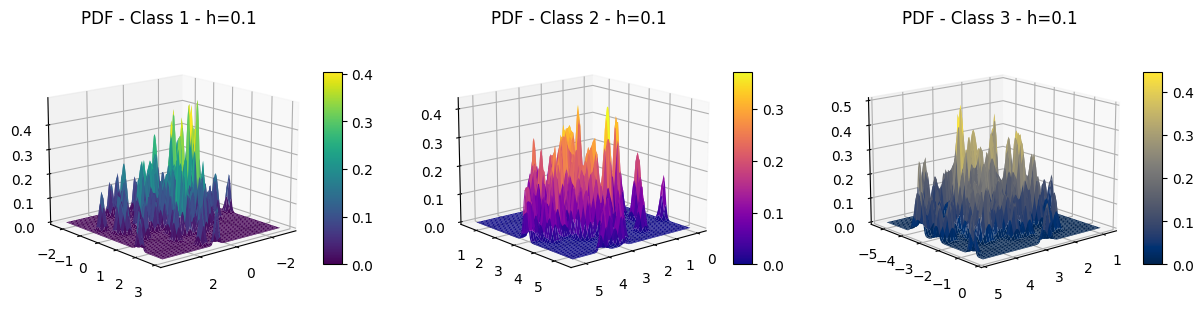

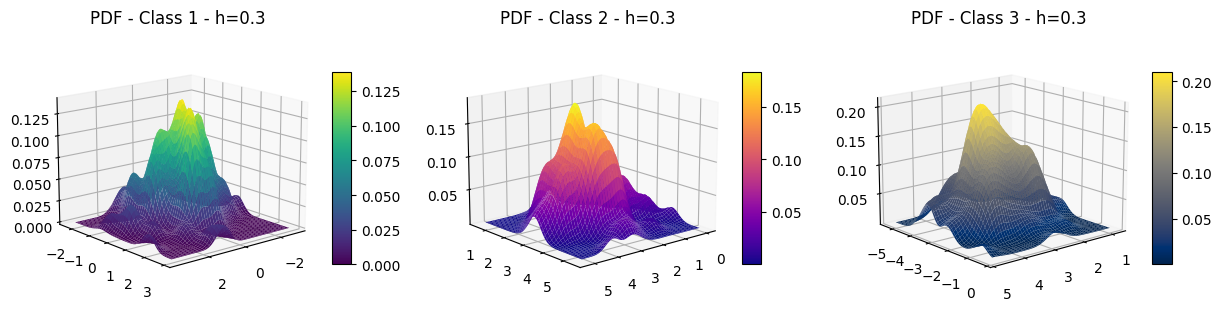

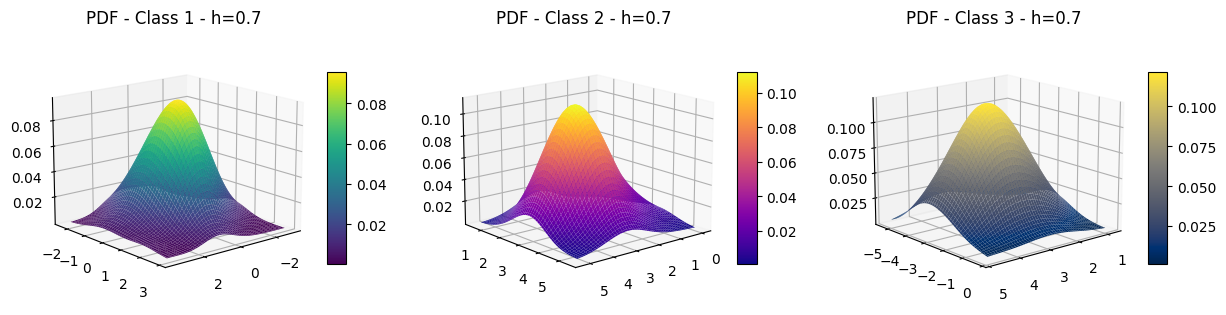

In [ ]:
for i in range(len(h)): # Do the same for the different values of h, make one plot for each class for every h
  fig = plt.figure(figsize=(15, 5))

  # Plot 1
  ax1 = fig.add_subplot(131, projection='3d')
  surf1 = ax1.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1_h[i], cmap='viridis')
  fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
  ax1.set_title(f'PDF - Class 1 - h={h[i]}')
  ax1.view_init(elev=15, azim=50)

  # Plot 2
  ax2 = fig.add_subplot(132, projection='3d')
  surf2 = ax2.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2_h[i], cmap='plasma')
  fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
  ax2.set_title(f'PDF - Class 2 - h={h[i]}')
  ax2.view_init(elev=15, azim=50)

  # Plot 3
  ax3 = fig.add_subplot(133, projection='3d')
  surf3 = ax3.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3_h[i], cmap='cividis')
  fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
  ax3.set_title(f'PDF - Class 3 - h={h[i]}')
  ax3.view_init(elev=15, azim=50)

  plt.show()

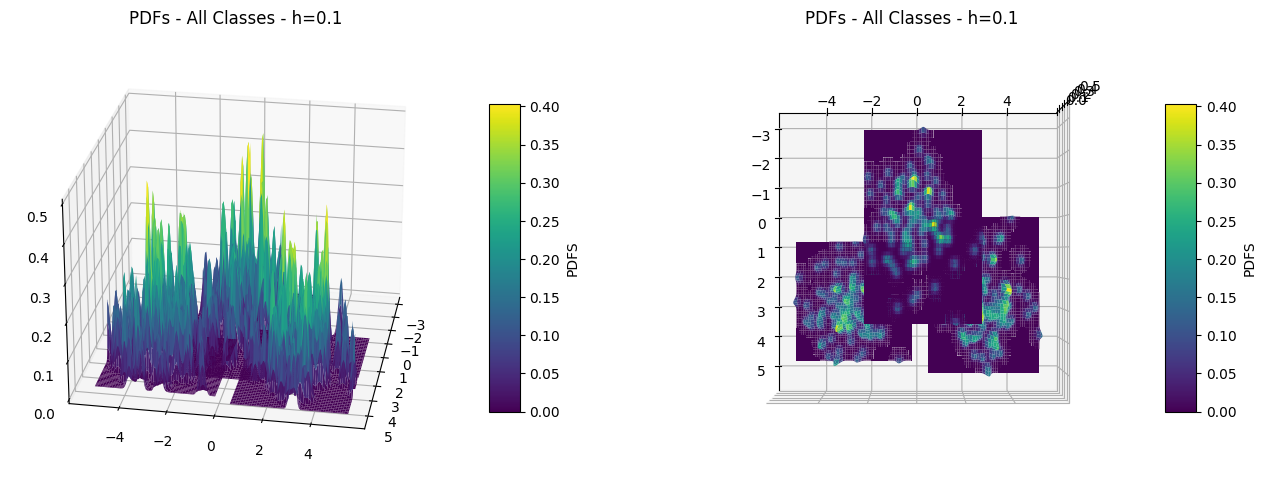

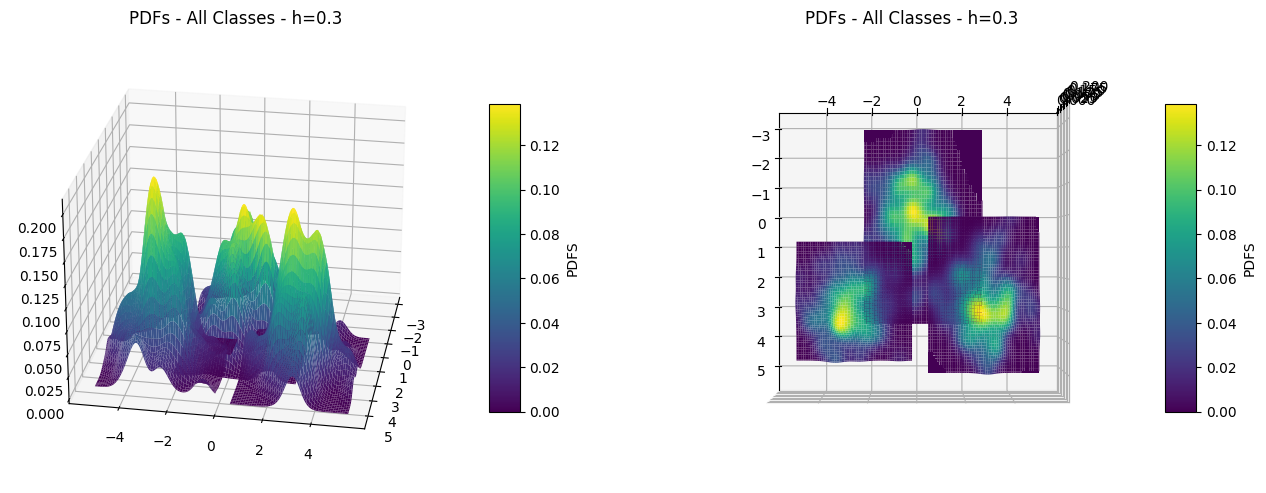

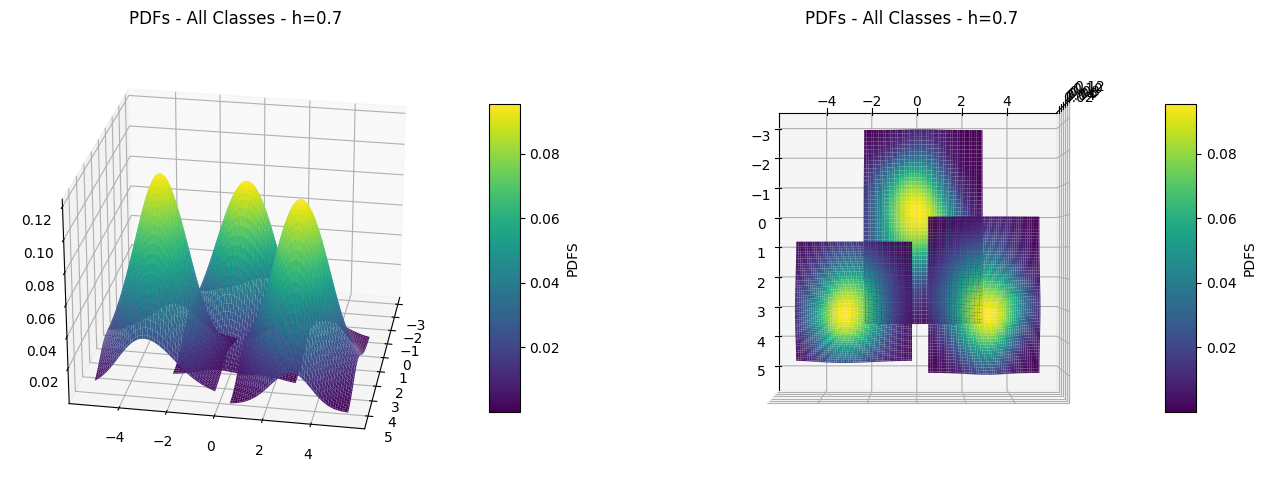

In [ ]:
for i in range(len(h)): # Do the same for the different values of h

  fig = plt.figure(figsize=(16, 8))

  # Plot 1, make one plot for every h with all the classes
  ax = fig.add_subplot(121, projection='3d')
  surf1 = ax.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1_h[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2_h[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3_h[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - h={h[i]}')
  ax.view_init(elev=25, azim=10)

  # Plot 2, make one plot for every h with all the classes, the same plot as before but we see it from above
  ax = fig.add_subplot(122, projection='3d')
  surf1 = ax.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1_h[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2_h[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3_h[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - h={h[i]}')
  ax.view_init(elev=90, azim=0)

  plt.show()

Εκτίμηση μόνο με το 25% των δεδομένων.

Τα διαγράμματα είναι λίγο διαφορετικά από αυτά που υπάρχουν στο report, γιατί όταν το έγραφα δεν είχα ρυθμίσει το seed.

In [ ]:
# Set a seed for reproducibility
np.random.seed(6)

# Randomly sample 25% of data from each class
sample_size = int(0.25 * len(X_class1_data))

# Randomly sample from  array and convert the result back to a NumPy array
X_class1_new_data = random.sample(X_class1_data.tolist(), sample_size)
X_class1_new_data = np.array(X_class1_new_data)

X_class2_new_data = random.sample(X_class2_data.tolist(), sample_size)
X_class2_new_data = np.array(X_class2_new_data)

X_class3_new_data = random.sample(X_class3_data.tolist(), sample_size)
X_class3_new_data = np.array(X_class3_new_data)

In [ ]:
# Find new min and max values for every feature and every class
min1 = np.min(X_class1_new_data, axis=0)
min2 = np.min(X_class2_new_data, axis=0)
min3 = np.min(X_class3_new_data, axis=0)

max1 = np.max(X_class1_new_data, axis=0)
max2 = np.max(X_class2_new_data, axis=0)
max3 = np.max(X_class3_new_data, axis=0)

In [ ]:
N = 100 # Choose to have N points in the grid, the grid will be NxN

# Make points in 1D for x1, x2 with equal step
X1_points_class1_new_grid = np.linspace(min1[0], max1[0], N)
X1_points_class2_new_grid = np.linspace(min2[0], max2[0], N)
X1_points_class3_new_grid = np.linspace(min3[0], max3[0], N)

X2_points_class1_new_grid = np.linspace(min1[1], max1[1], N)
X2_points_class2_new_grid = np.linspace(min2[1], max2[1], N)
X2_points_class3_new_grid = np.linspace(min3[1], max3[1], N)

# Make a 2D grid
X1_class1_new_grid, X2_class1_new_grid = np.meshgrid(X1_points_class1_new_grid, X2_points_class1_new_grid)
X1_class2_new_grid, X2_class2_new_grid = np.meshgrid(X1_points_class2_new_grid, X2_points_class2_new_grid)
X1_class3_new_grid, X2_class3_new_grid = np.meshgrid(X1_points_class3_new_grid, X2_points_class3_new_grid)

In [ ]:
# Same as before we calculate the pdfs using parzen estimation using only 25% of the initial data
# and keep all the pdfs for every value of h in a list for the plots
h = [0.1, 0.3, 0.7]
d = 2
pdfs1_h_new = []
pdfs2_h_new = []
pdfs3_h_new = []


for i in range(len(h)):
  pdf1 = []
  pdf2 = []
  pdf3 = []

  for x1, x2 in zip(X1_class1_new_grid.ravel(), X2_class1_new_grid.ravel()):
    final_pdf1_value = parzen_estimation([x1, x2], X_class1_new_data, h[i], d)
    pdf1.append(final_pdf1_value)
  pdf1 = np.asarray(pdf1).reshape(N, N)
  pdfs1_h_new.append(pdf1)

  for x1, x2 in zip(X1_class2_new_grid.ravel(), X2_class2_new_grid.ravel()):
    final_pdf2_value = parzen_estimation([x1, x2], X_class2_new_data, h[i], d)
    pdf2.append(final_pdf2_value)
  pdf2 = np.asarray(pdf2).reshape(N, N)
  pdfs2_h_new.append(pdf2)

  for x1, x2 in zip(X1_class3_new_grid.ravel(), X2_class3_new_grid.ravel()):
    final_pdf3_value = parzen_estimation([x1, x2], X_class3_new_data, h[i], d)
    pdf3.append(final_pdf3_value)
  pdf3 = np.asarray(pdf3).reshape(N, N)
  pdfs3_h_new.append(pdf3)

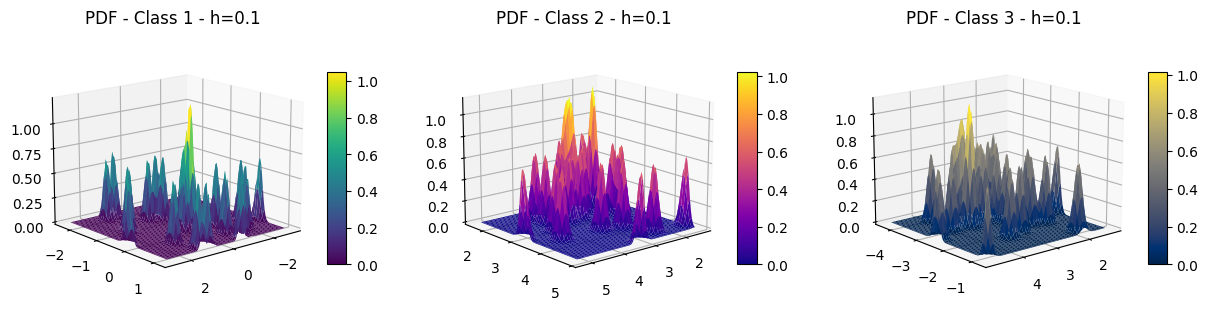

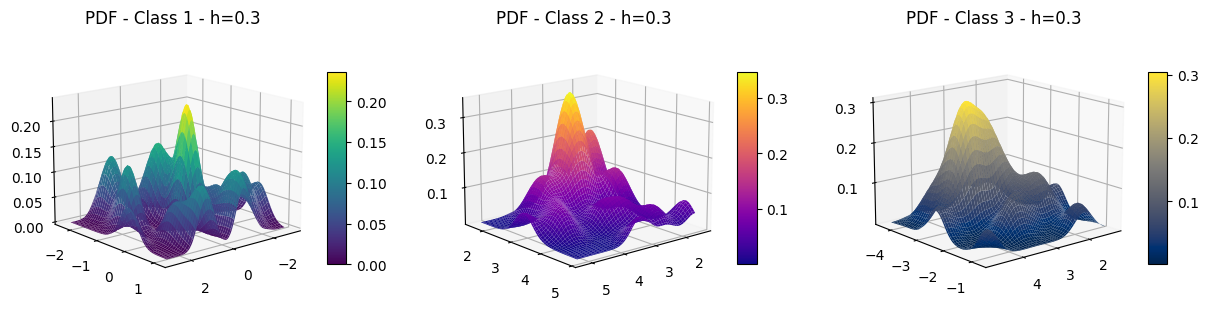

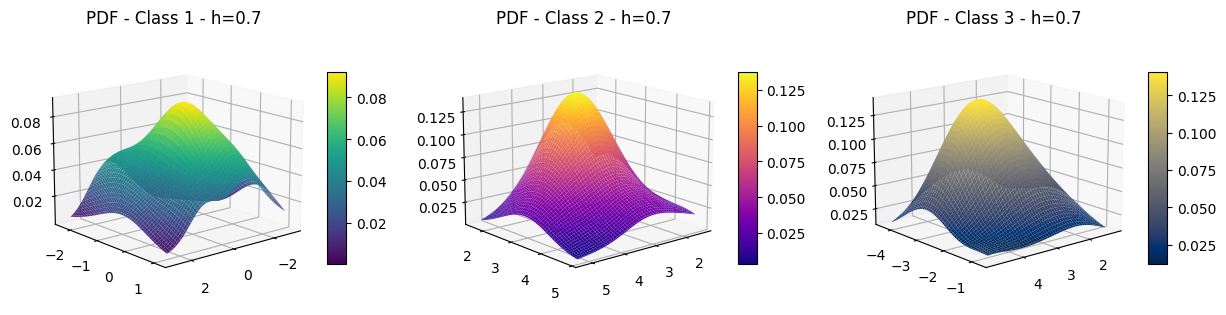

In [ ]:
# Same plots as before but using only 25% of the initial data
for i in range(len(h)):
  fig = plt.figure(figsize=(15, 5))

  # Plot 1
  ax1 = fig.add_subplot(131, projection='3d')
  surf1 = ax1.plot_surface(X1_class1_new_grid, X2_class1_new_grid, pdfs1_h_new[i], cmap='viridis')
  fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
  ax1.set_title(f'PDF - Class 1 - h={h[i]}')
  ax1.view_init(elev=15, azim=50)

  # Plot 2
  ax2 = fig.add_subplot(132, projection='3d')
  surf2 = ax2.plot_surface(X1_class2_new_grid, X2_class2_new_grid, pdfs2_h_new[i], cmap='plasma')
  fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
  ax2.set_title(f'PDF - Class 2 - h={h[i]}')
  ax2.view_init(elev=15, azim=50)

  # Plot 3
  ax3 = fig.add_subplot(133, projection='3d')
  surf3 = ax3.plot_surface(X1_class3_new_grid, X2_class3_new_grid, pdfs3_h_new[i], cmap='cividis')
  fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
  ax3.set_title(f'PDF - Class 3 - h={h[i]}')
  ax3.view_init(elev=15, azim=50)

  plt.show()

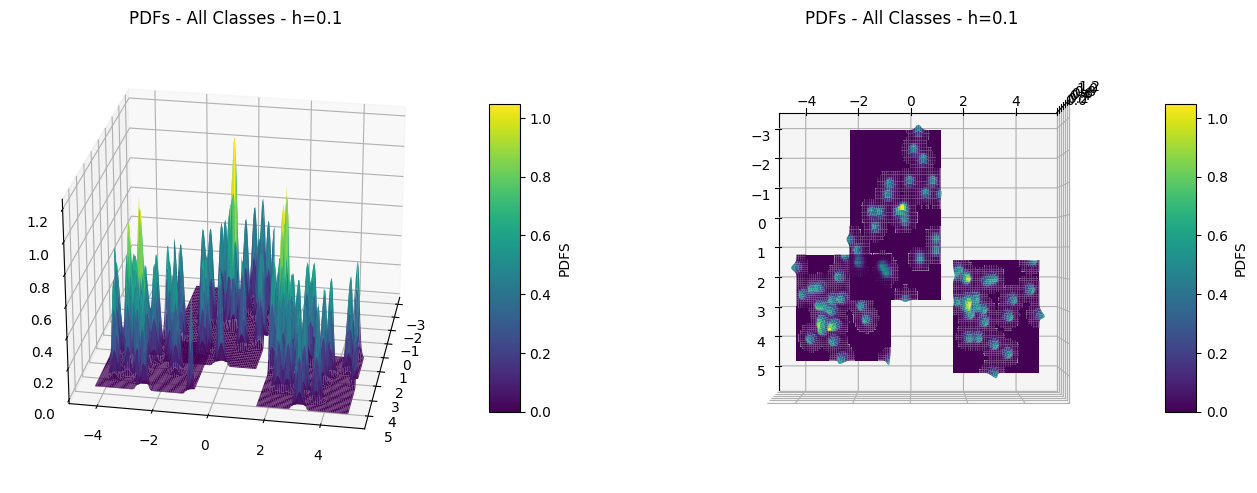

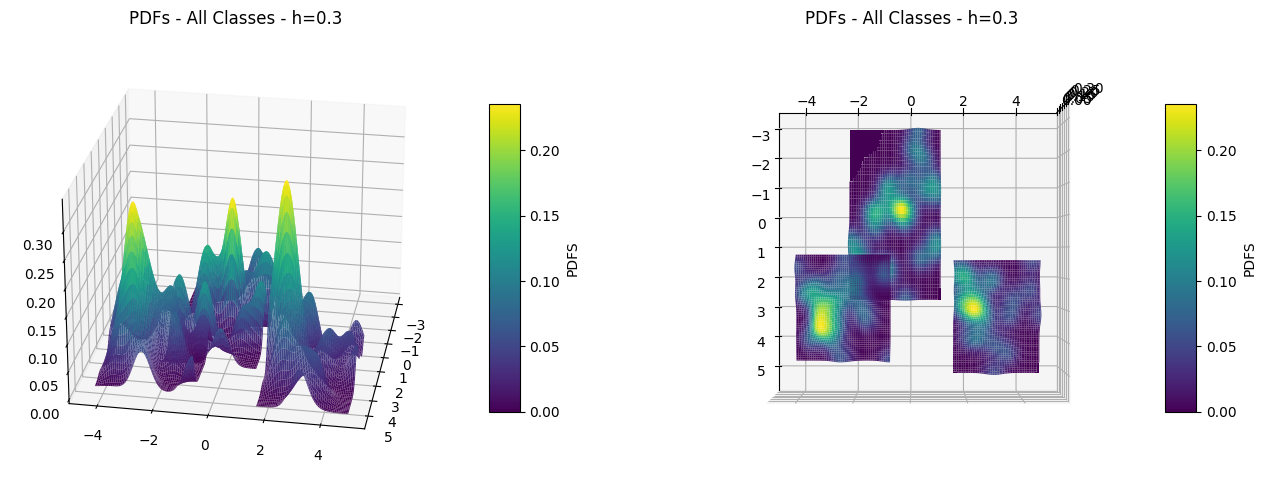

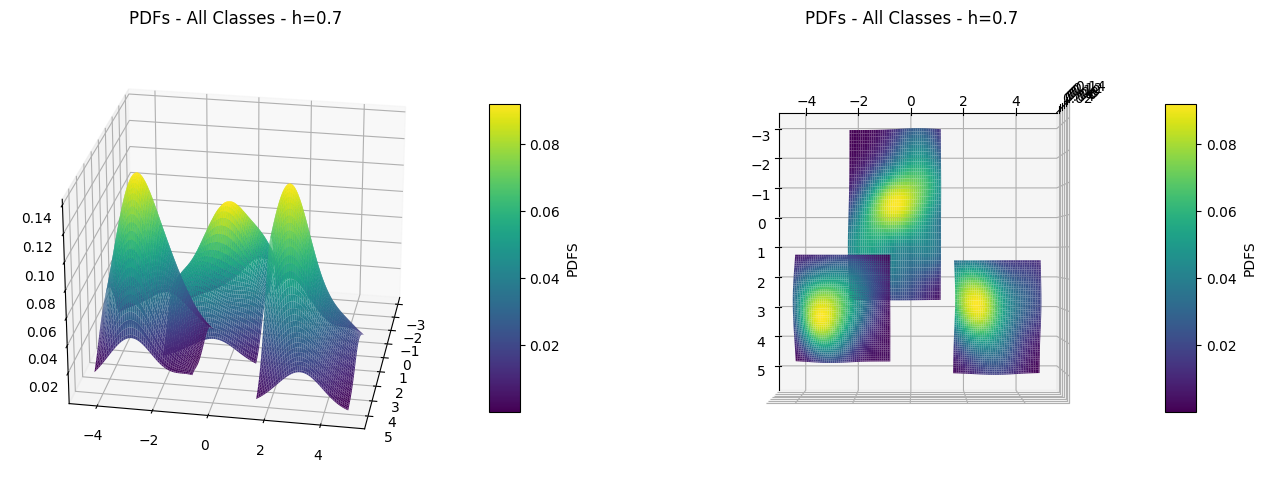

In [ ]:
# Same plots as before but using only 25% of the initial data
for i in range(len(h)):
  fig = plt.figure(figsize=(16, 8))

  # Plot 1
  ax = fig.add_subplot(121, projection='3d')
  surf1 = ax.plot_surface(X1_class1_new_grid, X2_class1_new_grid, pdfs1_h_new[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_new_grid, X2_class2_new_grid, pdfs2_h_new[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_new_grid, X2_class3_new_grid, pdfs3_h_new[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - h={h[i]}')
  ax.view_init(elev=25, azim=10)

  # Plot 2
  ax = fig.add_subplot(122, projection='3d')
  surf1 = ax.plot_surface(X1_class1_new_grid, X2_class1_new_grid, pdfs1_h_new[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_new_grid, X2_class2_new_grid, pdfs2_h_new[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_new_grid, X2_class3_new_grid, pdfs3_h_new[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - h={h[i]}')
  ax.view_init(elev=90, azim=0)

  plt.show()

In [ ]:
# Check for different h values, if the esimation is the same with less data
# In order to find for which h i have the best estimation using only 25% of the initial data
h = [0.1, 0.3, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 1.2, 1.5]
d = 2
pdfs1_h_new = []
pdfs2_h_new = []
pdfs3_h_new = []

# Same as before we calculate the pdfs using parzen estimation using only 25% of the initial data
# and keep all the pdfs for every value of h in a list for the plots
for i in range(len(h)):
  pdf1 = []
  pdf2 = []
  pdf3 = []

  for x1, x2 in zip(X1_class1_new_grid.ravel(), X2_class1_new_grid.ravel()):
    final_pdf1_value = parzen_estimation([x1, x2], X_class1_new_data, h[i], d)
    pdf1.append(final_pdf1_value)
  pdf1 = np.asarray(pdf1).reshape(N, N)
  pdfs1_h_new.append(pdf1)

  for x1, x2 in zip(X1_class2_new_grid.ravel(), X2_class2_new_grid.ravel()):
    final_pdf2_value = parzen_estimation([x1, x2], X_class2_new_data, h[i], d)
    pdf2.append(final_pdf2_value)
  pdf2 = np.asarray(pdf2).reshape(N, N)
  pdfs2_h_new.append(pdf2)

  for x1, x2 in zip(X1_class3_new_grid.ravel(), X2_class3_new_grid.ravel()):
    final_pdf3_value = parzen_estimation([x1, x2], X_class3_new_data, h[i], d)
    pdf3.append(final_pdf3_value)
  pdf3 = np.asarray(pdf3).reshape(N, N)
  pdfs3_h_new.append(pdf3)

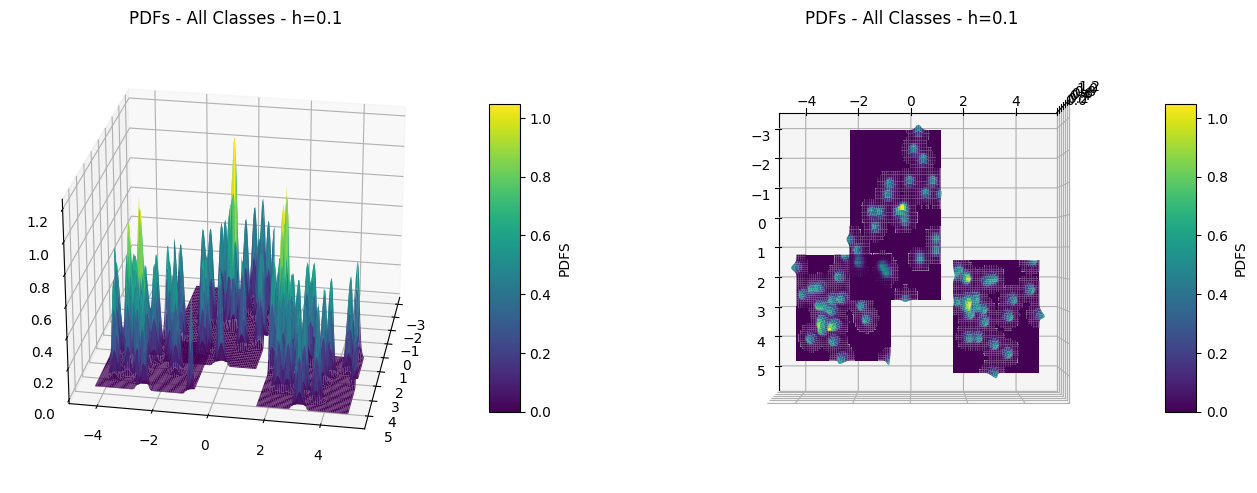

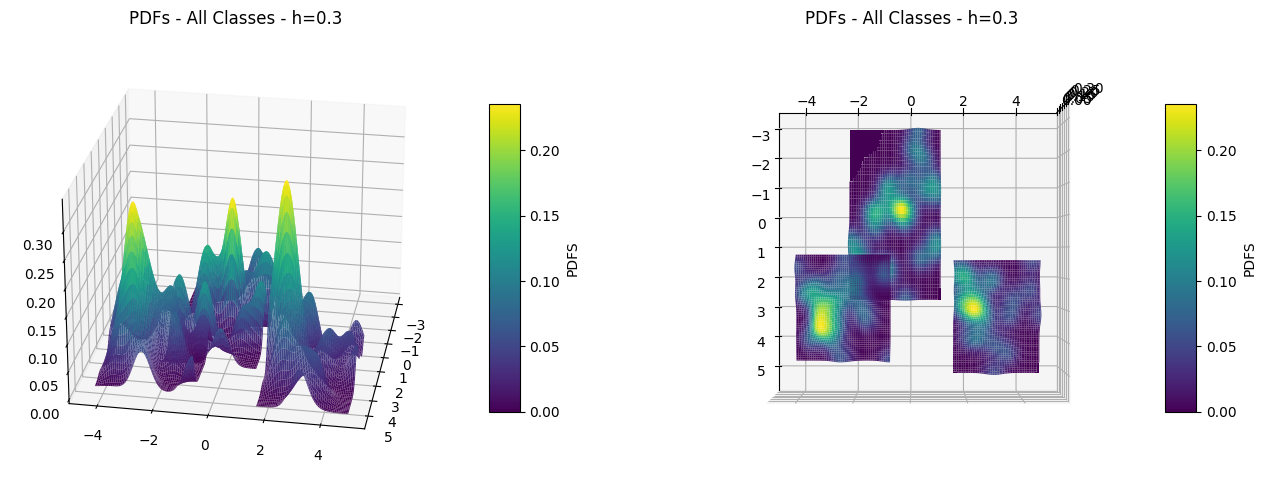

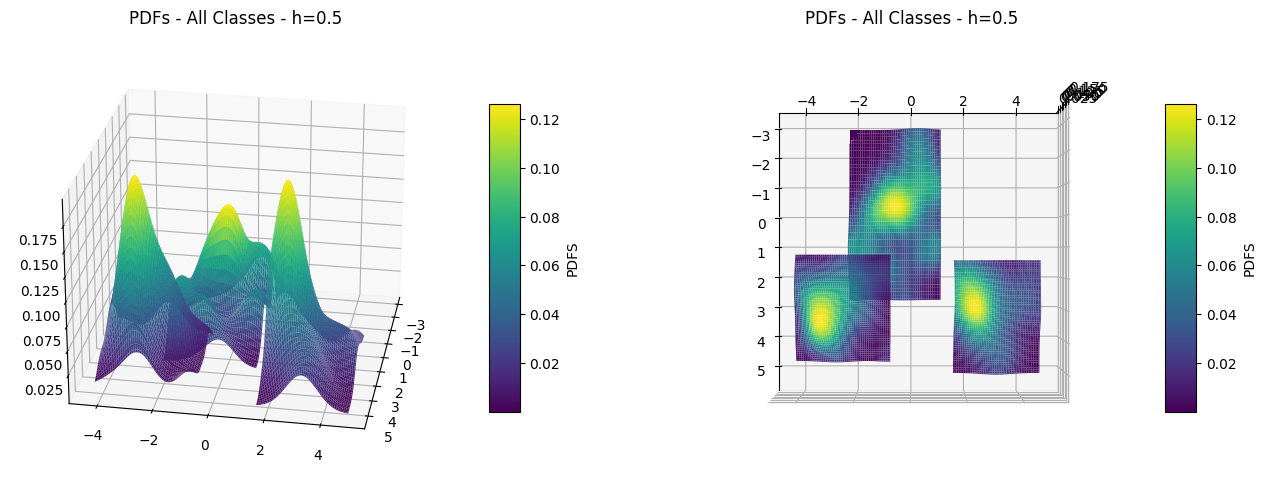

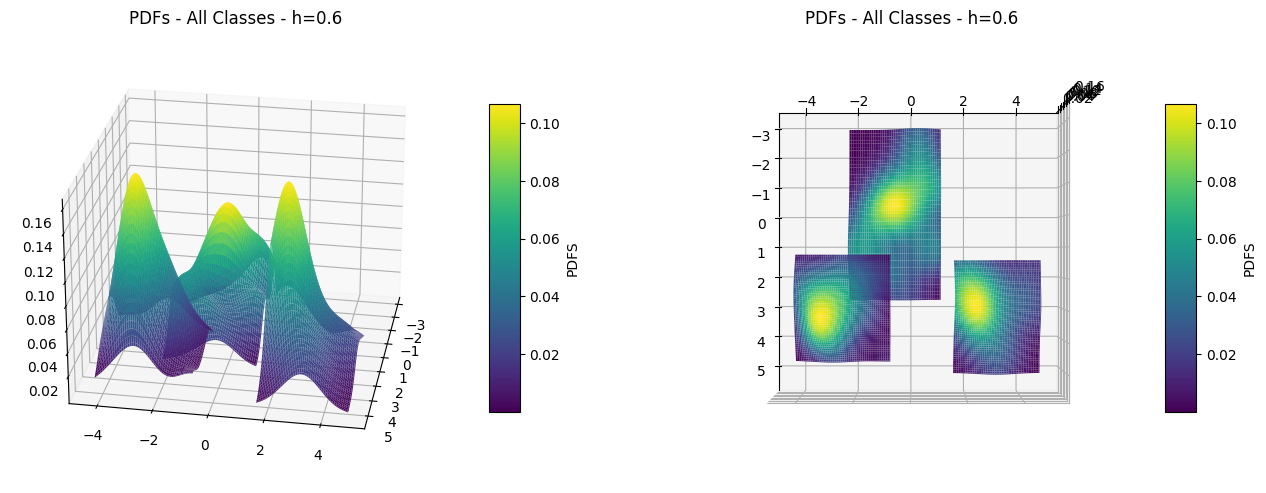

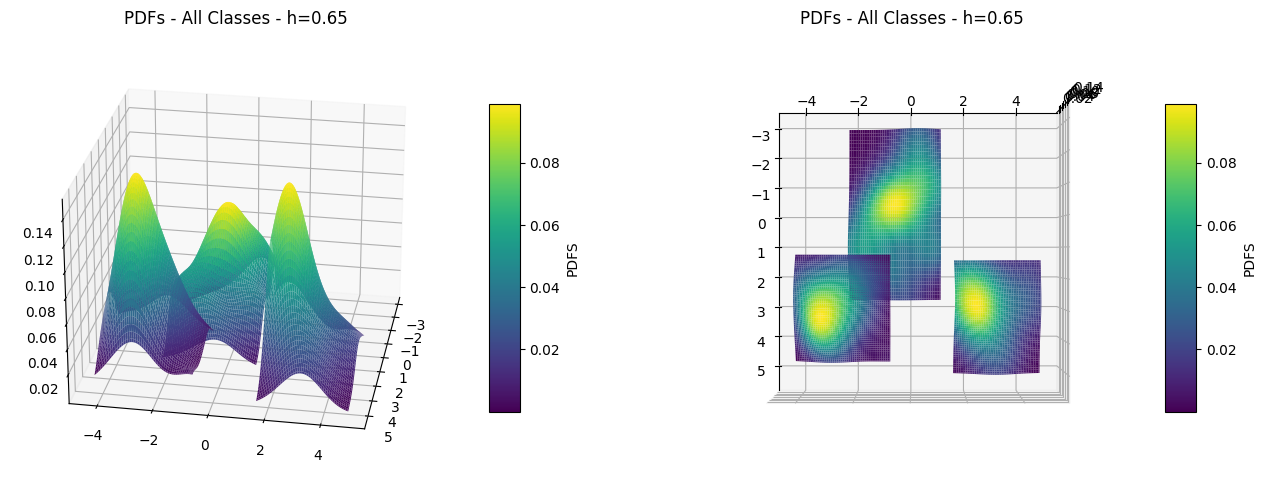

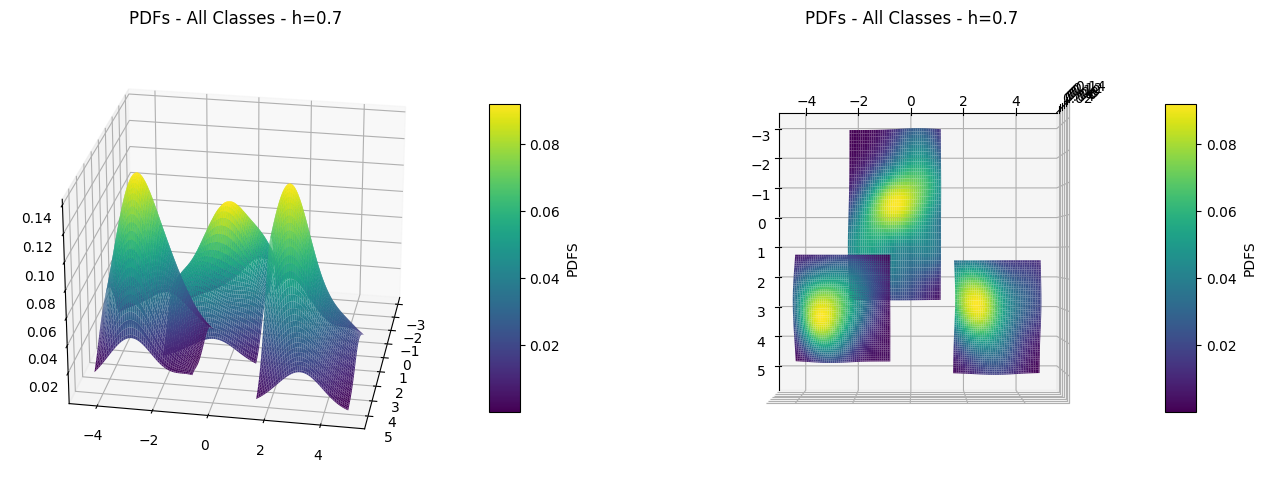

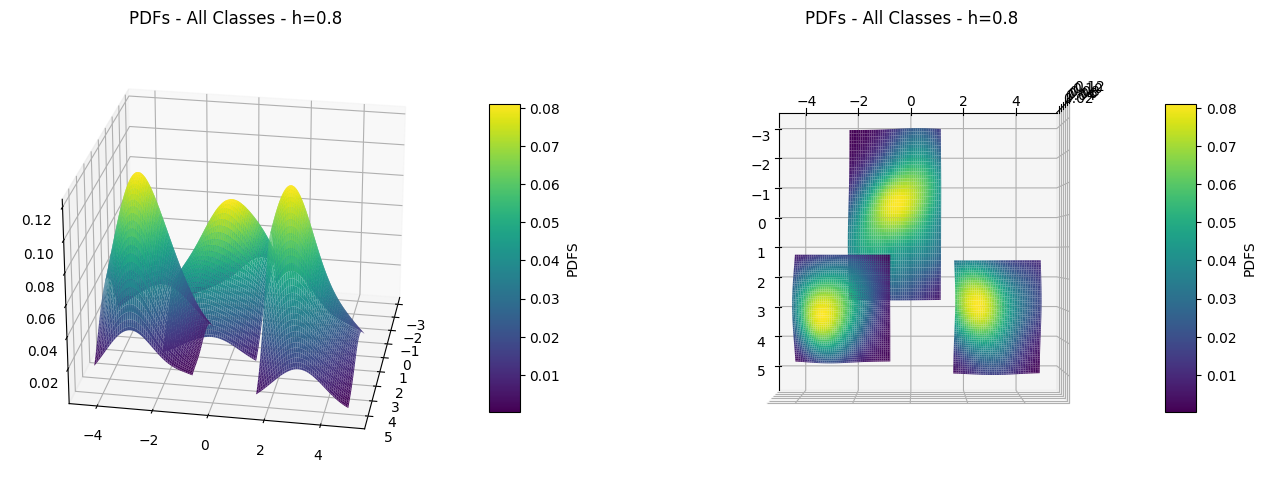

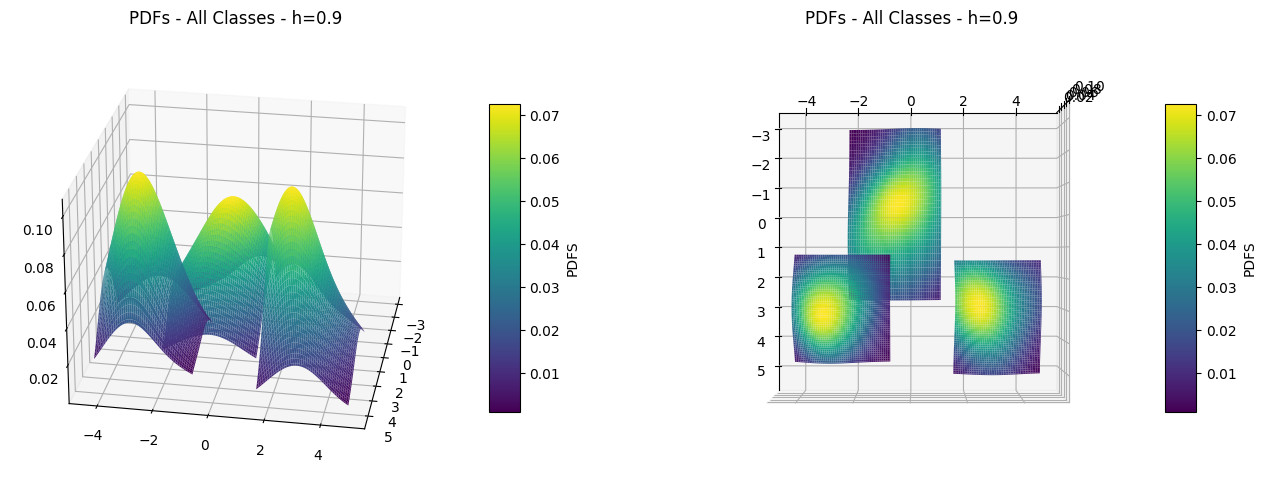

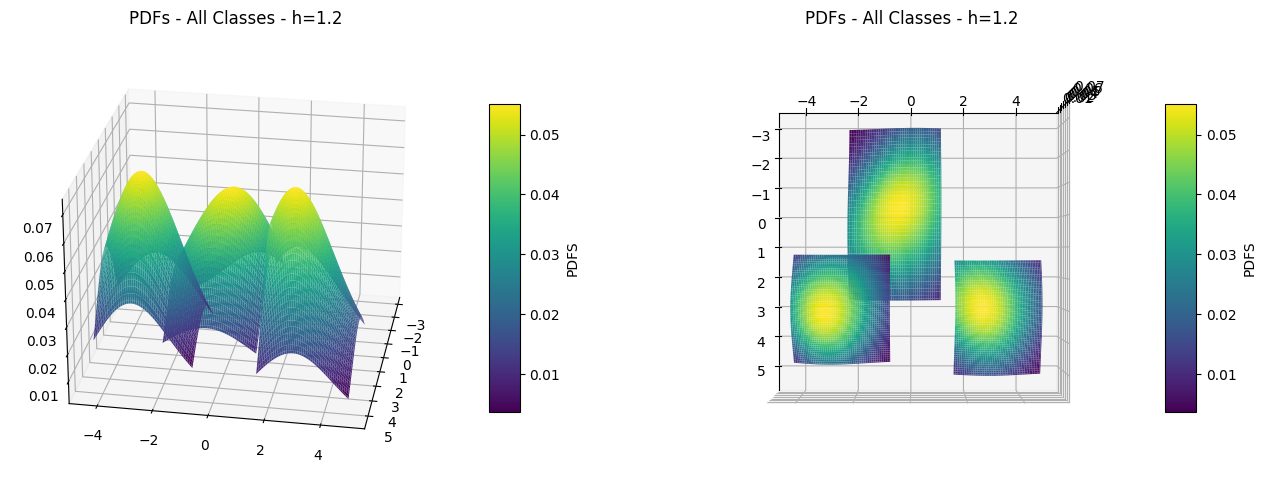

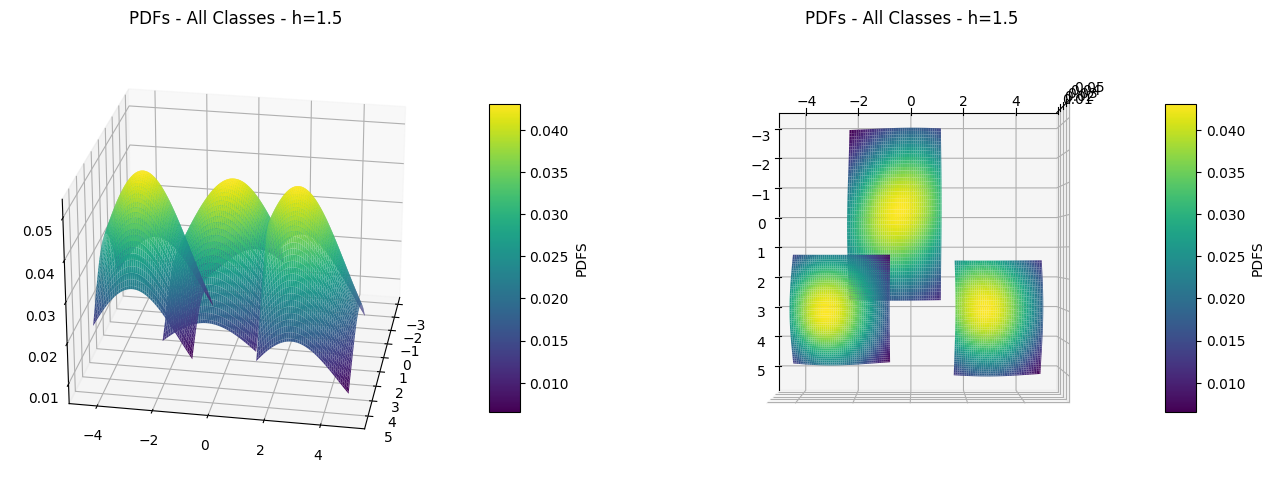

In [ ]:
# Same plots as before but using only 25% of the initial data for different values of h
for i in range(len(h)):
  fig = plt.figure(figsize=(16, 8))

  # Plot 1
  ax = fig.add_subplot(121, projection='3d')
  surf1 = ax.plot_surface(X1_class1_new_grid, X2_class1_new_grid, pdfs1_h_new[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_new_grid, X2_class2_new_grid, pdfs2_h_new[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_new_grid, X2_class3_new_grid, pdfs3_h_new[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - h={h[i]}')
  ax.view_init(elev=25, azim=10)

  # Plot 2
  ax = fig.add_subplot(122, projection='3d')
  surf1 = ax.plot_surface(X1_class1_new_grid, X2_class1_new_grid, pdfs1_h_new[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_new_grid, X2_class2_new_grid, pdfs2_h_new[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_new_grid, X2_class3_new_grid, pdfs3_h_new[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - h={h[i]}')
  ax.view_init(elev=90, azim=0)

  plt.show()

Με βάση τα παραπάνω διαγράμματα θα μπορούσαμε να επιλέξουμε h=0.5 αντί για h=0.6 που αναφέρω στο report, καθώς για το συγκεκριμένο random seed δε φαίνεται να υπάρχει overfitting για h=0.5.

Καλύτερα όμως για να συμπεριλάβουμε και άλλες περιπτώσεις (πολλά διαφορετικά seed) να πηγαίνουμε στο 0.6, για να ήμαστε σίγουροι ότι δε θα υπάρξει overfitting.

## Άσκηση 1.Β

In [ ]:
# We do the same as in the beginning of the notebook to be sure we have not overwrite the initial data,
# we have not but we do this in order to be sure
# Create separate arrays for each class, initial data
X_class1_data = x_data[class_1_indices]
X_class2_data = x_data[class_2_indices]
X_class3_data = x_data[class_3_indices]

# Find min and max values for every class
min1 = np.min(X_class1_data, axis=0)
min2 = np.min(X_class2_data, axis=0)
min3 = np.min(X_class3_data, axis=0)

max1 = np.max(X_class1_data, axis=0)
max2 = np.max(X_class2_data, axis=0)
max3 = np.max(X_class3_data, axis=0)

N = 100 # Choose to have N points in the grid, the grid will be NxN

# Make points in 1D for x1, x2 with equal step
X1_points_class1_grid = np.linspace(min1[0], max1[0], N)
X1_points_class2_grid = np.linspace(min2[0], max2[0], N)
X1_points_class3_grid = np.linspace(min3[0], max3[0], N)

X2_points_class1_grid = np.linspace(min1[1], max1[1], N)
X2_points_class2_grid = np.linspace(min2[1], max2[1], N)
X2_points_class3_grid = np.linspace(min3[1], max3[1], N)

# Make a 3D grid
X1_class1_grid, X2_class1_grid = np.meshgrid(X1_points_class1_grid, X2_points_class1_grid)
X1_class2_grid, X2_class2_grid = np.meshgrid(X1_points_class2_grid, X2_points_class2_grid)
X1_class3_grid, X2_class3_grid = np.meshgrid(X1_points_class3_grid, X2_points_class3_grid)

In [ ]:
# Calculate the pdf value for a specific point in the grid using KNN
def knn_estimation(grid_point, data_points, k):
  n = len(data_points) # How many samples there are in the dataset
  # Find Euclidean distances for a point x in the grid from every point in the dataset
  distances = np.linalg.norm((grid_point - data_points), ord=2, axis=1)
  # Sort array that contains distances, the sorted array contains distances by ascending order
  sorted_distances_index = np.argsort(distances, axis=0)
  # Radius of the circle is equal to the distance between point x of the grid and the k'th neighbour,
  # index starts from 0 so we need k-1 distance from the sorted array
  r = distances[sorted_distances_index[k-1]]
  V = np.pi * r ** 2 # V of a circle with radius r is V=πr^2
  return k/(n*V) # Estimated pdf value

In [ ]:
k = [3, 10, 30]
pdfs1_k = []
pdfs2_k = []
pdfs3_k = []

for i in range(len(k)): # Do the same for the different values of k
  pdf1 = []
  pdf2 = []
  pdf3 = []

  # Same as in a, but now for knn and different values of k
  # Iterate over every point in the grid, calculate the pdf value using knn estimation and append each value in a list for a specific k
  for x1, x2 in zip(X1_class1_grid.ravel(), X2_class1_grid.ravel()):
    final_pdf1_value = knn_estimation([x1, x2], X_class1_data, k[i])
    pdf1.append(final_pdf1_value)
  pdf1 = np.asarray(pdf1).reshape(N, N)
  pdfs1_k.append(pdf1)

  for x1, x2 in zip(X1_class2_grid.ravel(), X2_class2_grid.ravel()):
    final_pdf2_value = knn_estimation([x1, x2], X_class2_data, k[i])
    pdf2.append(final_pdf2_value)
  pdf2 = np.asarray(pdf2).reshape(N, N)
  pdfs2_k.append(pdf2)

  for x1, x2 in zip(X1_class3_grid.ravel(), X2_class3_grid.ravel()):
    final_pdf3_value = knn_estimation([x1, x2], X_class3_data, k[i])
    pdf3.append(final_pdf3_value)
  pdf3 = np.asarray(pdf3).reshape(N, N)
  pdfs3_k.append(pdf1)

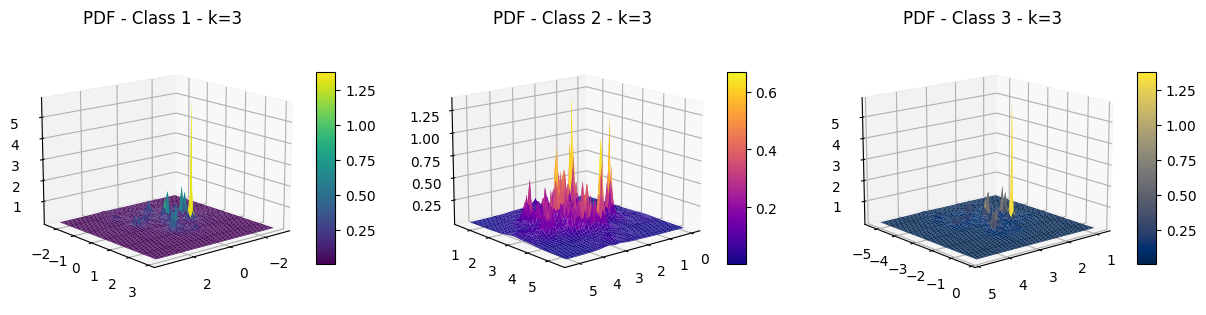

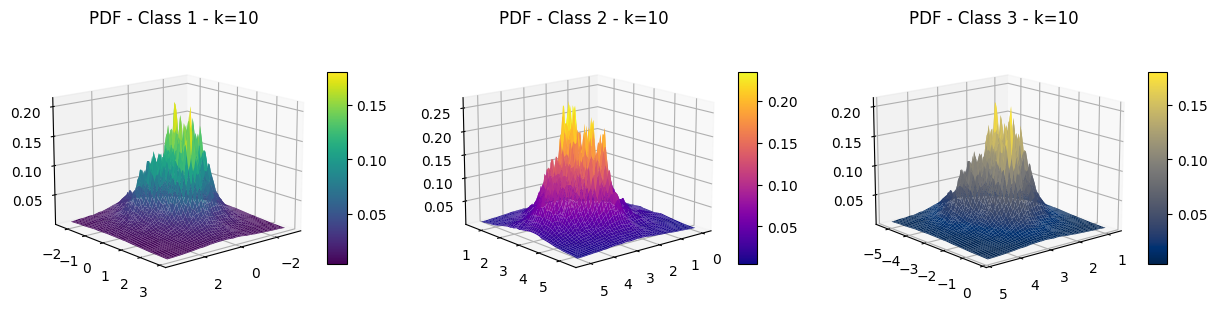

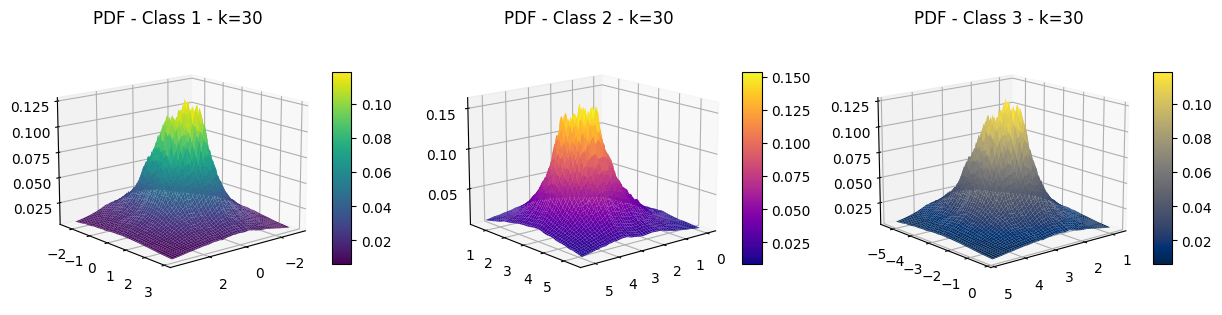

In [ ]:
for i in range(len(k)):
  fig = plt.figure(figsize=(15, 5))

  # Plot 1
  ax1 = fig.add_subplot(131, projection='3d')
  surf1 = ax1.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1_k[i], cmap='viridis')
  fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
  ax1.set_title(f'PDF - Class 1 - k={k[i]}')
  ax1.view_init(elev=15, azim=50)

  # Plot 2
  ax2 = fig.add_subplot(132, projection='3d')
  surf2 = ax2.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2_k[i], cmap='plasma')
  fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
  ax2.set_title(f'PDF - Class 2 - k={k[i]}')
  ax2.view_init(elev=15, azim=50)

  # Plot 3
  ax3 = fig.add_subplot(133, projection='3d')
  surf3 = ax3.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3_k[i], cmap='cividis')
  fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
  ax3.set_title(f'PDF - Class 3 - k={k[i]}')
  ax3.view_init(elev=15, azim=50)

  plt.show()

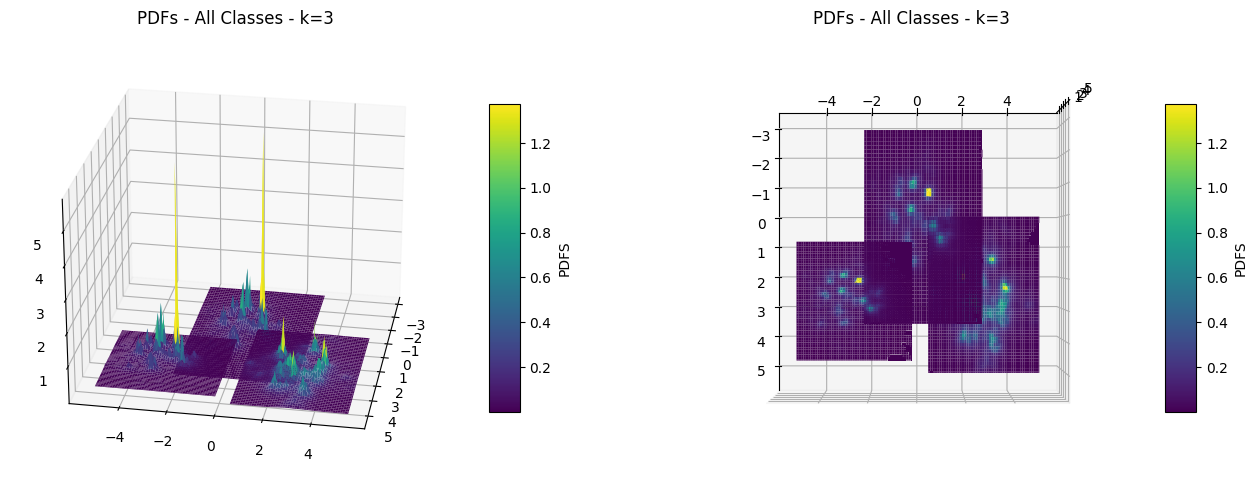

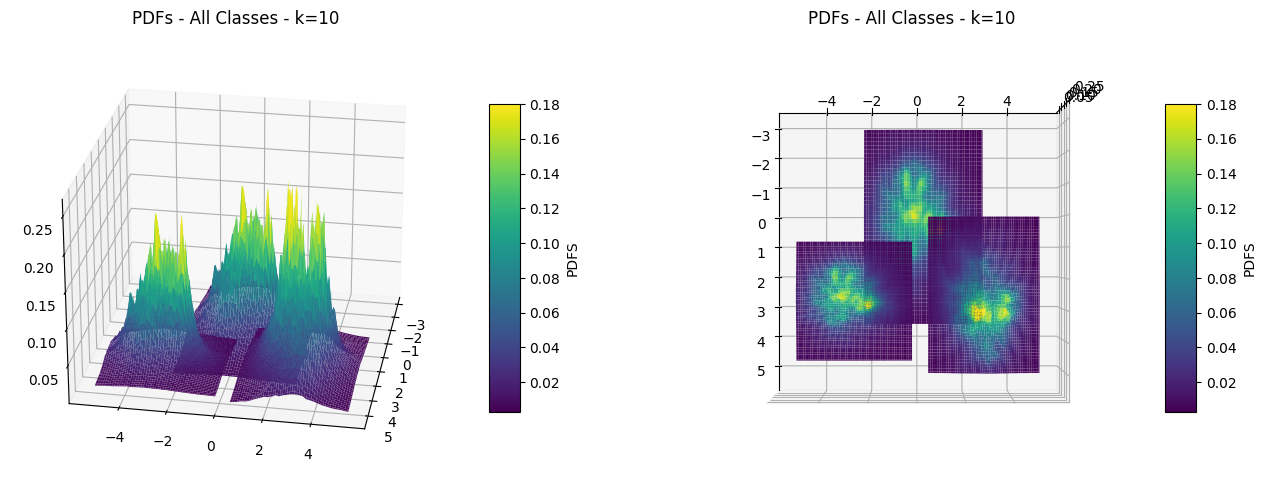

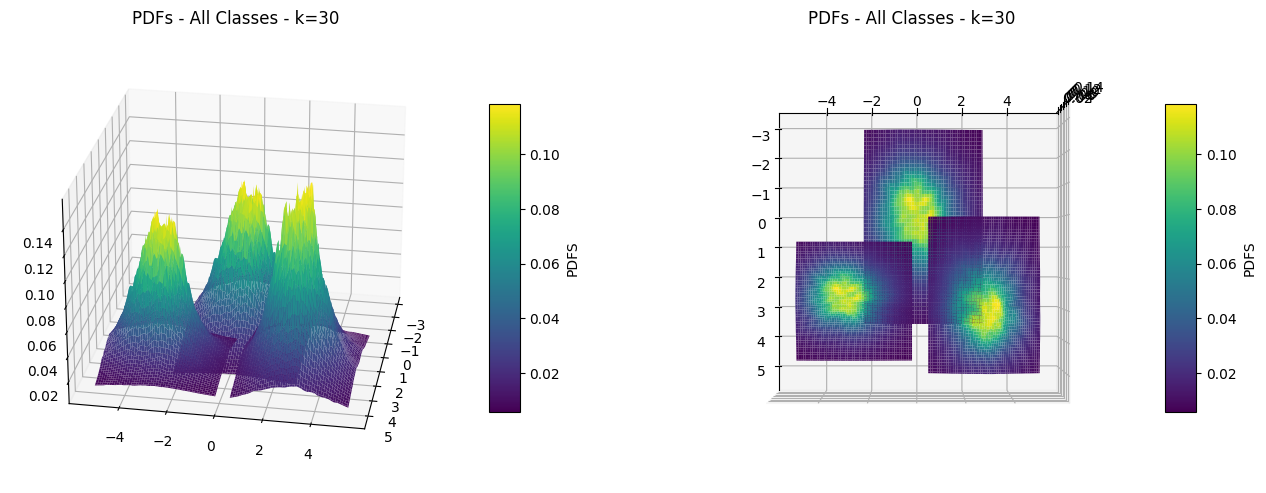

In [ ]:
for i in range(len(k)):

  fig = plt.figure(figsize=(16, 8))

  # Plot 1
  ax = fig.add_subplot(121, projection='3d')
  surf1 = ax.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1_k[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2_k[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3_k[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - k={k[i]}')
  ax.view_init(elev=25, azim=10)

  # Plot 2
  ax = fig.add_subplot(122, projection='3d')
  surf1 = ax.plot_surface(X1_class1_grid, X2_class1_grid, pdfs1_k[i], cmap='viridis')
  surf2 = ax.plot_surface(X1_class2_grid, X2_class2_grid, pdfs2_k[i], cmap='viridis')
  surf3 = ax.plot_surface(X1_class3_grid, X2_class3_grid, pdfs3_k[i], cmap='viridis')

  fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
  ax.set_title(f'PDFs - All Classes - k={k[i]}')
  ax.view_init(elev=90, azim=0)

  plt.show()

## Άσκηση 1.C

In [ ]:
# Find min and max values of each class, we did this before too
min1 = np.min(X_class1_data, axis=0)
min2 = np.min(X_class2_data, axis=0)
min3 = np.min(X_class3_data, axis=0)

max1 = np.max(X_class1_data, axis=0)
max2 = np.max(X_class2_data, axis=0)
max3 = np.max(X_class3_data, axis=0)

# I dont want empty space when i plot the decision boundaries, so i keep the min value from all the min values
# and the max value from all the max values
min_x1 = min(min1[0], min2[0], min3[0])
min_x2 = min(min1[1], min2[1], min3[1])
max_x1 = max(max1[0], max2[0], max3[0])
max_x2 = max(max1[1], max2[1], max3[1])

In [ ]:
N = 300 # Now i have only one grid

# Make points in 1D for x1, x2 with equal step
X1_points_grid = np.linspace(min_x1, max_x1, N)
X2_points_grid = np.linspace(min_x2, max_x2, N)

# Make a 2D grid
X1_grid, X2_grid = np.meshgrid(X1_points_grid, X2_points_grid)

In [ ]:
number_of_classes = 3
d = 2 # x1, x2 features, dimension
h = [0.1, 0.3, 1.5]
# prior = 1/number_of_classes # apriori is the same for every class, so i can ignore it

pdfs1_h = []
pdfs2_h = []
pdfs3_h = []

# Calculate pdf values for every class for different values of h and store in lists
# At the end we have 3 lists that each one of them contains 3 arrays NxN
for i in range(len(h)):
  pdf1 = []
  pdf2 = []
  pdf3 = []
  for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel()):
    final_pdf1_value = parzen_estimation([x1, x2], X_class1_data, h[i], d)
    pdf1.append(final_pdf1_value)
  pdf1 = np.asarray(pdf1).reshape(N, N)
  pdfs1_h.append(pdf1)

  for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel()):
    final_pdf2_value = parzen_estimation([x1, x2], X_class2_data, h[i], d)
    pdf2.append(final_pdf2_value)
  pdf2 = np.asarray(pdf2).reshape(N, N)
  pdfs2_h.append(pdf2)

  for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel()):
    final_pdf3_value = parzen_estimation([x1, x2], X_class3_data, h[i], d)
    pdf3.append(final_pdf3_value)
  pdf3 = np.asarray(pdf3).reshape(N, N)
  pdfs3_h.append(pdf3)

In [ ]:
predictions_h = [] # We will store in this list the lists with the predictions for every h
for k in range(len(h)):
  predictions = [] # We will store in this list all the labels that we will predict

  # Iterate over every point in the grid, means we iterate over every pdf value for a specific h
  for i in range(pdfs1_h[k].shape[0]):
    for j in range(pdfs1_h[k].shape[1]):
      # Find the array index with the maximum element at the current position
      # We have a list with 3 arrays inside, these arrays contain the pdf values for each class
      # We find in every element of each array, which array has the biggest pdf value, compare arrays element by element
      # Compare element 0,0 of each array and keep the class label with the biggest pdf in that element, do that for every other element
      max_index = np.argmax([pdfs1_h[k][i, j], pdfs2_h[k][i, j], pdfs3_h[k][i, j]])
      predictions.append(max_index) # Keep the predicted label
  predictions = np.asarray(predictions).reshape(N, N) # Reshape list as array NxN, that array contains the predicted labels
  predictions_h.append(predictions) # Keep in this list for every h the array with the predicted labels

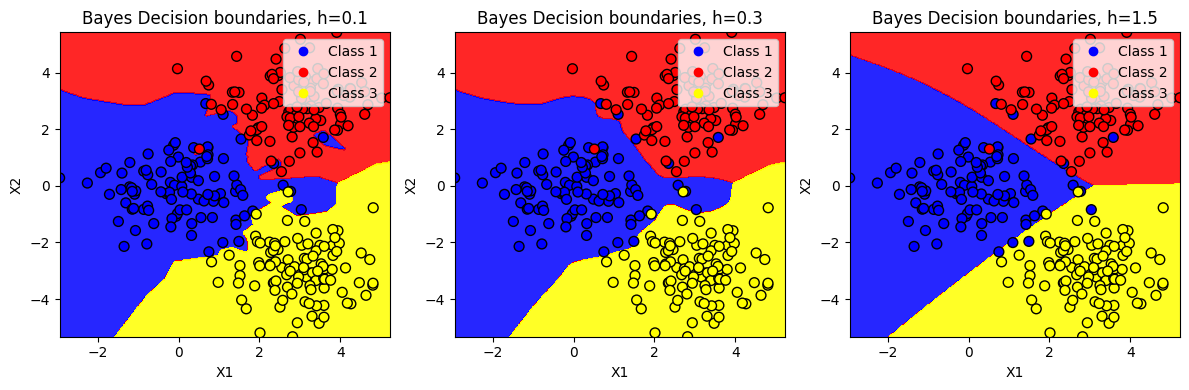

In [ ]:
# Plot the decision areas for every h, we can also see the points of the dataset,
# the areas with different colours are in fact the points of the grid

# Choose the colours you want for points and areas, not the default cmaps of matrlotlib
cmap = ListedColormap(['blue', 'red', 'yellow'])

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(h), figsize=(12, 4))

for i, ax in enumerate(axes):
  # Plot the decision areas with colours
  # alpha regulates the transparency, we want the decision areas to be a little lighter
  ax.contourf(X1_grid, X2_grid, predictions_h[i], cmap=cmap, alpha=0.85)

  # Scatter plot with the original data points
  scatter = ax.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap=cmap, edgecolors='k', marker='o', s=50)
  legend_labels = ['Class 1', 'Class 2', 'Class 3']
  ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

  # Add labels and title
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')
  ax.set_title(f'Bayes Decision boundaries, h={h[i]}')

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

In [ ]:
# We can visualize the plots for the pdf of the classes for different values of h
# It is better to use different grids for each class for the visualization

# for i in range(len(h)):
#   fig = plt.figure(figsize=(16, 8))

#   # If value of pdf is very close to zero, put nan, otherwise we cannot see clearly the plots
    # because values close to zero are overlapping with pdf curves
#   pdfs1_h[i] = np.where(pdfs1_h[i] < 0.01, np.nan, pdfs1_h[i])
#   pdfs2_h[i] = np.where(pdfs2_h[i] < 0.01, np.nan, pdfs2_h[i])
#   pdfs3_h[i] = np.where(pdfs3_h[i] < 0.01, np.nan, pdfs3_h[i])

#   # Plot 1
#   ax = fig.add_subplot(121, projection='3d')
#   surf1 = ax.plot_surface(X1_grid, X2_grid, pdfs1_h[i], cmap='viridis')
#   surf2 = ax.plot_surface(X1_grid, X2_grid, pdfs2_h[i], cmap='viridis')
#   surf3 = ax.plot_surface(X1_grid, X2_grid, pdfs3_h[i], cmap='viridis')

#   fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
#   ax.set_title(f'PDFs - All Classes - h={h[i]}')
#   ax.view_init(elev=25, azim=10)

#   # Plot 2
#   ax = fig.add_subplot(122, projection='3d')
#   surf1 = ax.plot_surface(X1_grid, X2_grid, pdfs1_h[i], cmap='viridis')
#   surf2 = ax.plot_surface(X1_grid, X2_grid, pdfs2_h[i], cmap='viridis')
#   surf3 = ax.plot_surface(X1_grid, X2_grid, pdfs3_h[i], cmap='viridis')

#   fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label='PDFS')
#   ax.set_title(f'PDFs - All Classes - h={h[i]}')
#   ax.view_init(elev=90, azim=0)

#   plt.show()

## Άσκηση 1.D

In [ ]:
# For a specific point in the grid, find the nearest k neighbours of the points in the dataset
# and see in which category they belong to, we assign the grid point in the class in which the
# more nearest neighbours belong to
def knn_classifier(grid_point, data_points, k, number_of_classes):
  n = len(data_points) # for every sample in dataset, 300 samples in the dataset

  distances = np.linalg.norm((grid_point - data_points), ord=2, axis=1)
  sorted_distances_index = np.argsort(distances, axis=0)
  NN = data_points[sorted_distances_index[0:k]] # Keep k nearest neighbours (k neighbours 0 to k-1)
  votes = np.zeros([number_of_classes, 1]) # keep the votes of each class

  for i in range(k): # k neighbours, check in which class they belong
    row_to_search = np.array(NN[i, :]) # for each neighbour find in which row of the data it it
    indices = np.where(np.all(data_points == row_to_search, axis=1)) # if the row is in the array get the index

    # In the array votes, increment votes[0] if one of k nearest neighbours belongs to class 1, same for calss 2 and votes[1], same for calss 3 and votes[2]
    # That can happen because in the original data we have class 1 in the first 100 rows, class 2 in the next 100 rows and class 3 at the end
    if 0 <= indices[0][0] < n/number_of_classes: # if index is in the range 0-99 -> class1
      votes[0] += 1
    elif n/number_of_classes <= indices[0][0] < n/number_of_classes * 2: # if index is in the range 100-199 -> class2
      votes[1] += 1
    else: # if index is in the range 200-299 -> class3
      votes[2] += 1
  return np.argmax(votes[:, 0]) # Find which class has the more votes

In [ ]:
number_of_classes = 3
k = [3, 8, 30]
predictions_k = [] # Keep the arrays with the predicted labels for different values of k

for i in range(len(k)):
  predictions = [] # Keep the predicted labels
  # Iterate over each point in the grid and make a prediction
  for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel()):
    # Put the predicted label into a list for each point in the grid (for the plot)
    predictions.append(knn_classifier([x1, x2], x_data, k[i], number_of_classes))
  predictions = np.asarray(predictions).reshape(N, N) # Reshape as an array NxN
  predictions_k.append(predictions)

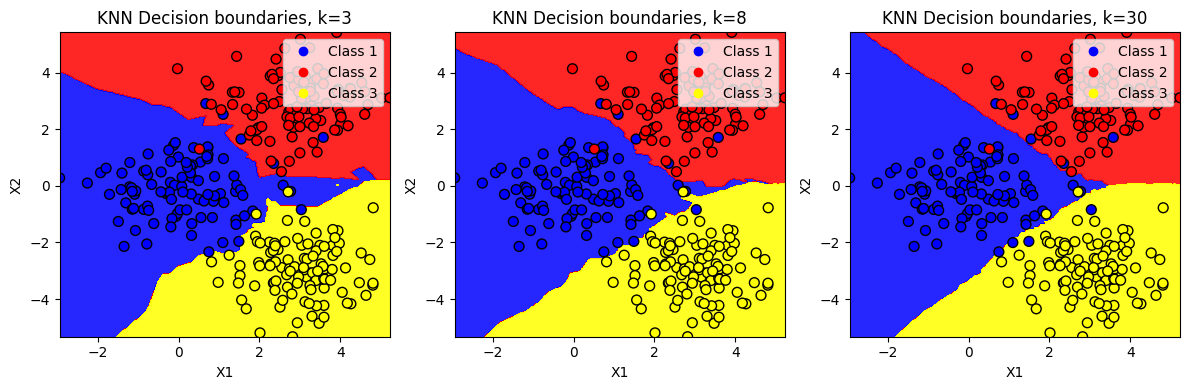

In [ ]:
# Plot the decision areas for every k, we can also see the points of the dataset,
# the areas with different colours are in fact the points of the grid

# Choose the colours you want for points and areas, not the default cmaps of matrlotlib
cmap = ListedColormap(['blue', 'red', 'yellow'])

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(k), figsize=(12, 4))

for i, ax in enumerate(axes):
    # Plot the decision areas with colours
    ax.contourf(X1_grid, X2_grid, predictions_k[i], cmap=cmap, alpha=0.85)

    # Scatter plot with  the original data points
    # alpha regulates the transparency, we want the decision areas to be a little lighter
    scatter = ax.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap=cmap, edgecolors='k', marker='o', s=50)
    legend_labels = ['Class 1', 'Class 2', 'Class 3']
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

    # Add labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(f'KNN Decision boundaries, k={k[i]}')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

# Άσκηση 2

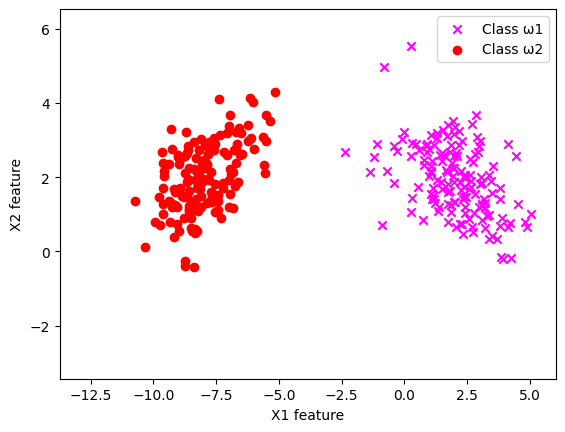

In [ ]:
rng = np.random.default_rng(seed=42) # Random seed for reproducability
number_of_samples = 150
m1, m2 = [2, 2], [-8, 2] # mean values
s1, s2 = [[2, -0.5], [-0.5, 1]], [[1, 0.5], [0.5, 1]] # cov matrices

# Create samples that follow normal distribution with 2 features
class1_x1, class1_x2 = rng.multivariate_normal(m1, s1, number_of_samples).T
class2_x1, class2_x2 = rng.multivariate_normal(m2, s2, number_of_samples).T

# Values (min, max) of the two axes
plt.xlim(min(min(class1_x1), min(class2_x1))-3, max(max(class1_x1), max(class2_x1))+1)
plt.ylim(min(min(class1_x2), min(class2_x2))-3, max(max(class1_x2), max(class2_x2))+1)

# Scatter plots
plt.scatter(class1_x1, class1_x2, color='magenta', marker='x', label='Class ω1')
plt.scatter(class2_x1, class2_x2, color='red', marker='o', label='Class ω2')

# Labels and legend
plt.xlabel('X1 feature')
plt.ylabel('X2 feature')
plt.legend()
plt.show()

## Άσκηση 2.Α

The starting weights are: [ 0.49671415 -0.1382643   0.64768854]
Number of wrong predictions are: 14 at iteration 5
Number of wrong predictions are: 10 at iteration 10
Number of wrong predictions are: 7 at iteration 15
Number of wrong predictions are: 6 at iteration 20
Number of wrong predictions are: 5 at iteration 25
Number of wrong predictions are: 4 at iteration 30
Number of wrong predictions are: 3 at iteration 35
Number of wrong predictions are: 3 at iteration 40
Number of wrong predictions are: 3 at iteration 45
Number of wrong predictions are: 2 at iteration 50
Number of wrong predictions are: 2 at iteration 55
Number of wrong predictions are: 2 at iteration 60
Number of wrong predictions are: 2 at iteration 65
Number of wrong predictions are: 2 at iteration 70
Number of wrong predictions are: 2 at iteration 75
Number of wrong predictions are: 2 at iteration 80
Final number of wrong predictions are: 0
The final weights are: [2.68671415 7.69492832 5.88197823]


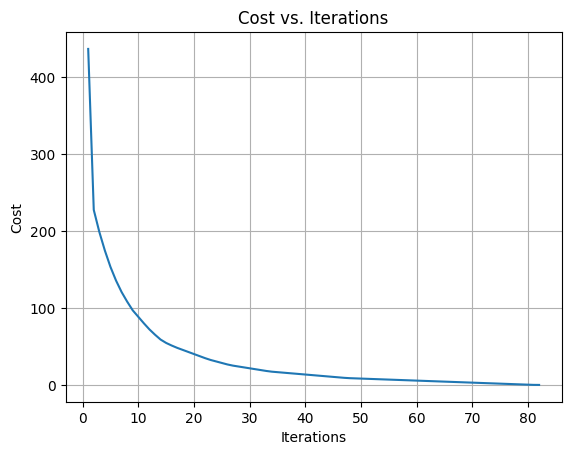

In [ ]:
# Gradient Descent
lr = 0.01 # learning rate
number_of_features = 2

# Put data in an array, each column is a feature, 1st column is 1
x_class1 = np.column_stack((np.ones(number_of_samples), class1_x1, class1_x2))
x_class2 = np.column_stack((np.ones(number_of_samples), class2_x1, class2_x2))
y_class1 = np.ones(number_of_samples) # label 1, class 1 -> Wx>0
y_class2 = -np.ones(number_of_samples) # label -1, class 2 -> Wx<0

# Extract features and labels
x = np.row_stack((x_class1, x_class2)) # (300, 3)
y = np.concatenate((y_class1, y_class2)) # (300,)

seed = 42 # Random seed

def batch_perceptron(seed, x, y, number_of_features, plot_cost=False):
  np.random.seed(seed) # Set random seed
  w = np.random.randn(number_of_features + 1) # Initialize weights to random values, we need w0, w1, w2
  print("The starting weights are:", w)

  cost = [] # Store cost of each iteration in a list (for plot)
  iterations = [] # Store iteration number
  wrong_predictions = number_of_samples # Initialize wrong predictions at the beginning in a value != 0, it can be another value
  i = 0

  while(wrong_predictions): # Run the algorithm until all the predictions are correct, the problem is simple, a solution can be found
    i += 1
    iterations.append(i)
    predictions = np.multiply(x.dot(w), y) # shape (300,), wxy
    cost.append(-np.sum(predictions[predictions < 0])) # Sum only wrong classified for the cost

    wrong_class = np.where(predictions < 0, 1, 0) # If predictions < 0 assign 1, else 0 -> if prediction is wrong in that index value is 1
    wrong_predictions = np.sum(wrong_class) # Number of wrong predictions

    # Compute gradient
    grad = -x.T.dot(wrong_class * y) # (3,), Calculate gradient

    # Update Parameters
    w = w - lr * grad # w is (3,), Update weights

    # Compute predictions based on the current model
    # new_predictions = x.dot(w)

    if i%5 == 0: # Print every 5 iterations
      print("Number of wrong predictions are:", wrong_predictions, "at iteration", i)

  print("Final number of wrong predictions are:", wrong_predictions)
  print("The final weights are:", w)

  if plot_cost: # if parameter of function is True
    # Plot the cost vs. iterations
    plt.plot(iterations, cost, linestyle='-')
    plt.title('Cost vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

  return w

w = batch_perceptron(seed=seed, x=x, y=y, number_of_features=number_of_features, plot_cost = True) # Use batch percetron and make a plot of the cost

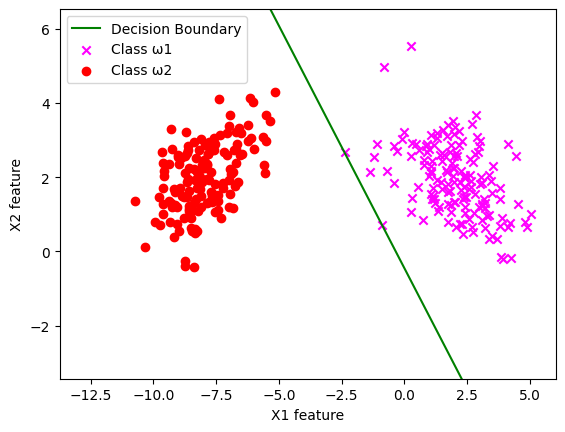

In [ ]:
w0, w1, w2 = w[0], w[1], w[2] # Weights
x1_values = np.linspace(-6, 4, 100)
x2_values = (-w0 - w1 * x1_values) / w2 # w0 + w1*x1 + w2*x2 = 0

# Plot classes and decision boundary
plt.xlim(min(min(class1_x1), min(class2_x1))-3, max(max(class1_x1), max(class2_x1))+1)
plt.ylim(min(min(class1_x2), min(class2_x2))-3, max(max(class1_x2), max(class2_x2))+1)
plt.plot(x1_values, x2_values, color='green', label='Decision Boundary')
plt.scatter(class1_x1, class1_x2, color='magenta', marker='x', label='Class ω1')
plt.scatter(class2_x1, class2_x2, color='red', marker='o', label='Class ω2')

# plot some points to show that they are classified wrong, as an example
# a1 = np.array([-2, 0, -2.5, -3, -1])
# a2 = np.array([1, -1, 0, 2, 0])
# plt.scatter(a1, a2, color='black', marker='x')

plt.xlabel('X1 feature')
plt.ylabel('X2 feature')
plt.legend()
plt.show()

## Άσκηση 2.B

In [ ]:
# Make an array with all the data, column 1 is 1, column 2 is feature 1, column 3 is feature 2
x = np.row_stack((x_class1, x_class2))
x_svm = x[:, 1:] # Keep only 2nd and 3rd column for SVM, function of sklearn needs only features

In [ ]:
# Train a linear SVM and get the weights, bias, support vectors
clf = svm.SVC(kernel='linear')
clf.fit(x_svm, y)
support_vectors = clf.support_vectors_
coefficients = clf.coef_
intercept = clf.intercept_

In [ ]:
print("Number of support vectors is:", len(support_vectors))

Number of support vectors is: 3


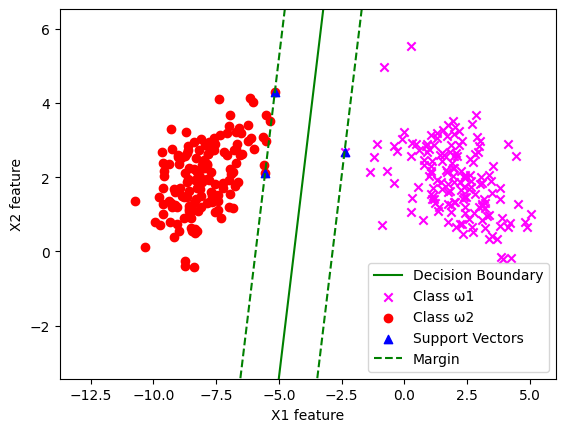

In [ ]:
w0 = intercept # bias, w0
w1, w2 = coefficients[0][0], coefficients[0][1] # weights

# Values to make the line
x1_values = np.linspace(-6, 0, 100)
x2_values = (-w0 - w1 * x1_values) / w2 # w0 + w1*x1 + w2*x2 = 0

# Plot classes and decision boundary
plt.xlim(min(min(class1_x1), min(class2_x1))-3, max(max(class1_x1), max(class2_x1))+1)
plt.ylim(min(min(class1_x2), min(class2_x2))-3, max(max(class1_x2), max(class2_x2))+1)
plt.plot(x1_values, x2_values, color='green', label='Decision Boundary')
plt.scatter(class1_x1, class1_x2, color='magenta', marker='x', label='Class ω1')
plt.scatter(class2_x1, class2_x2, color='red', marker='o', label='Class ω2')

# plot support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], color='blue', marker='^', label='Support Vectors')

# plot margin
margin = 1 / np.sqrt(w1**2 + w2**2) # 1/||w||
margin_x1 = x1_values + w1 * margin**2
margin_x2 = x2_values + w2 * margin**2
margin_x1_neg = x1_values - w1 * margin**2
margin_x2_neg = x2_values - w2 * margin**2
plt.plot(margin_x1, margin_x2, 'g--', label='Margin')
plt.plot(margin_x1_neg, margin_x2_neg, 'g--')

# Labels and legend
plt.xlabel('X1 feature')
plt.ylabel('X2 feature')
plt.legend()
plt.show()

# Άσκηση 3

Πρέπει να κάνουμε upload το φάκελο wine.zip στο colab.

In [ ]:
!ls

Data_ex1.txt  sample_data  wine.zip


In [ ]:
import os
if not os.path.exists('wine.data'): # If it is not already unzipped
    !unzip wine.zip

Archive:  wine.zip
  inflating: Index                   
  inflating: wine.data               
  inflating: wine.names              


In [ ]:
wine_dataframe =  pd.read_csv('wine.data', sep=",", header=None) # read file as dataframe which is separated with ,
print("Number of samples is", wine_dataframe.shape[0], "and number of features is", wine_dataframe.shape[1]-1)

Number of samples is 178 and number of features is 13


In [ ]:
wine_dataframe

0      1     2     3     4    5     6     7     8     9      10    11  \
0     1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29   5.64  1.04   
1     1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28   4.38  1.05   
2     1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81   5.68  1.03   
3     1  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18   7.80  0.86   
4     1  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82   4.32  1.04   
..   ..    ...   ...   ...   ...  ...   ...   ...   ...   ...    ...   ...   
173   3  13.71  5.65  2.45  20.5   95  1.68  0.61  0.52  1.06   7.70  0.64   
174   3  13.40  3.91  2.48  23.0  102  1.80  0.75  0.43  1.41   7.30  0.70   
175   3  13.27  4.28  2.26  20.0  120  1.59  0.69  0.43  1.35  10.20  0.59   
176   3  13.17  2.59  2.37  20.0  120  1.65  0.68  0.53  1.46   9.30  0.60   
177   3  14.13  4.10  2.74  24.5   96  2.05  0.76  0.56  1.35   9.20  0.61   

       12    13  
0    3.92  1065  
1    3.40  1050  
2    3.17  1185  
3    3.45  1480  
4    2.93   735  
..    ...   ...  
173  1.74   740  
174  1.56   750  
175  1.56   835  
176  1.62   840  
177  1.60   560  

[178 rows x 14 columns]

In [ ]:
# Extract the first column (labels) and convert it to a NumPy array
y = wine_dataframe.iloc[:, 0].values
# Extract features and convert it to a NumPy array
x = wine_dataframe.iloc[:, 1:].values

print(y.shape)
print(x.shape)

(178,)
(178, 13)


In [ ]:
# Count samples of each class
count_1 = (wine_dataframe.iloc[:, 0] == 1).sum()
print("Count of 1 in the first column:", count_1)
count_2 = (wine_dataframe.iloc[:, 0] == 2).sum()
print("Count of 2 in the first column:", count_2)
count_3 = (wine_dataframe.iloc[:, 0] == 3).sum()
print("Count of 3 in the first column:", count_3)

Count of 1 in the first column: 59
Count of 2 in the first column: 71
Count of 3 in the first column: 48


## Άσκηση 3.Α

In [ ]:
# keep only c2 and c3 classes (labels 2 and 3)
dataframe = wine_dataframe[(wine_dataframe.iloc[:, 0] == 2) | (wine_dataframe.iloc[:, 0] == 3)]

# keep only 5 first features
x = dataframe.iloc[:, 1:6].values
y = dataframe.iloc[:, 0].values

print(x.shape)
print(y.shape)

(119, 5)
(119,)


In [ ]:
# Split ratio
train_ratio = 0.5 # train is 50% of the initial samples
val_ratio = 0.25 # val is 25% of the initial samples
test_ratio = 0.25 # test is 25% of the initial samples
seed = 1234

# Split the dat
# stratify is used in order to have the same number of samples in each class when the data will be splitted
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=1-train_ratio, stratify=y, random_state=seed)
# Split the data, val is 50% of X_temp and test is 50% of X_temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + val_ratio), stratify=y_temp, random_state=seed)

In [ ]:
print("For class 2")
print("Numbers of samples of the training set is:", y_train[y_train==2].shape[0])
print("Numbers of samples of the validation set is:", y_val[y_val==2].shape[0])
print("Numbers of samples of the test set is:", y_test[y_test==2].shape[0])

print("For class 3")
print("Numbers of samples of the training set is:", y_train[y_train==3].shape[0])
print("Numbers of samples of the validation set is:", y_val[y_val==3].shape[0])
print("Numbers of samples of the test set is:", y_test[y_test==3].shape[0])

For class 2
Numbers of samples of the training set is: 35
Numbers of samples of the validation set is: 18
Numbers of samples of the test set is: 18
For class 3
Numbers of samples of the training set is: 24
Numbers of samples of the validation set is: 12
Numbers of samples of the test set is: 12


In [ ]:
print("Numbers of samples of the whole dataset is:", x.shape[0])
print("Numbers of samples of the training set is:", X_train.shape[0])
print("Numbers of samples of the validation set is:", X_val.shape[0])
print("Numbers of samples of the test set is:", X_test.shape[0])

Numbers of samples of the whole dataset is: 119
Numbers of samples of the training set is: 59
Numbers of samples of the validation set is: 30
Numbers of samples of the test set is: 30


## Άσκηση 3.B

Αρχκά εκπαιδεύουμε τον svm στο σύνολο εκπαίδευσης (training set) με τις default παραμέτρους και υπολογίζουμε την ακρίβεια στο σύνολο δοκιμής (test set).

In [ ]:
# Function to train and test an SVM classifier
# We can choose C, kernel and we can print the classification report if we want
def train_test_smv(X_train, y_train, X_test, y_test, c=1, kernel='linear', report=False):
  clf = svm.SVC(kernel=kernel, C=c) # The classifier
  # Train the classifier using training set
  clf.fit(X_train, y_train)
  # predictions = clf.predict(X_train) # Make predictions in the training set if you want -> Not useful, this is very biased
  # print(f"Training accuracy: {accuracy_score(y_train, predictions) * 100:.2f}%")

  # Test the classifier using test set
  predictions = clf.predict(X_test)
  print(f"Test accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%") # Print the accuracy

  if report:
    print("\n", classification_report(y_test, predictions)) # Print the classification report

  return accuracy_score(y_test, predictions) # return accuracy

In [ ]:
test_acc = train_test_smv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, report=True) # With C=1 and linear kernel

Test accuracy: 90.00%

               precision    recall  f1-score   support

           2       0.89      0.94      0.92        18
           3       0.91      0.83      0.87        12

    accuracy                           0.90        30
   macro avg       0.90      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



Για να ρυθμίσουμε το c πρέπει να χρησιμοποιήσουμε την ακόλουθη διαδικασία:

Εκπαιδεύουμε τον svm στο σύνολο εκπαίδευσης (training set) κάθε φορά χρησιμοποιώντας διαφορετική τιμή για το C και υπολογίζουμε την ακρίβεια στο σύνολο επικύρωσης (val set).

In [ ]:
# Function to find the best value for parameter C
# Takes as input a list containing values of C
def finetune_c(X_train, y_train, X_val, y_val, values_list, kernel='linear'):
  best_accuracy = 0
  for c in values: # For every C value in the list
    clf = svm.SVC(kernel=kernel, C=c) # Classifier
    clf.fit(X_train, y_train) # Train
    predictions = clf.predict(X_val) # Make predictions
    acc = accuracy_score(y_val, predictions) # Calculate accuracy

    if acc > best_accuracy: # If current C scores higher accuracy, keep this
      best_accuracy = acc
      best_c = c

  print(f"Best C value: {best_c}, Best accuracy in validation set: {round(best_accuracy*100, 2)}%")
  return best_c # return the value of C that scored the higher accuracy

In [ ]:
# A list containing all the values of C we want to test
values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 100, 200, 300, 500, 800, 1000, 1200, 1500, 2000, 5000]
best_c = finetune_c(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, values_list=values)

Best C value: 0.5, Best accuracy in validation set: 90.0%


In [ ]:
test_acc = train_test_smv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, c=best_c) # best_c = 0.5, using the splits with seed

Test accuracy: 93.33%


In [ ]:
error = 1-test_acc # Compute error
round(error, 4)

0.0667

## Άσκηση 3.C

In [ ]:
classification_error = []

for i in range(1, 6): # We want to find best C for 5 random splits
  seed = i*1234 # Another random seed for every iteration, another random split
  X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=1-train_ratio, stratify=y, random_state=seed)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + val_ratio), stratify=y_temp, random_state=seed)

  best_c = finetune_c(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, values_list=values) # Find best C
  test_acc = train_test_smv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, c=best_c) # Calculate test accuracy
  print("")
  classification_error.append(1-test_acc) # keep errors in a list

Best C value: 0.5, Best accuracy in validation set: 90.0%
Test accuracy: 93.33%

Best C value: 0.1, Best accuracy in validation set: 86.67%
Test accuracy: 73.33%

Best C value: 5, Best accuracy in validation set: 86.67%
Test accuracy: 86.67%

Best C value: 0.01, Best accuracy in validation set: 86.67%
Test accuracy: 60.00%

Best C value: 0.05, Best accuracy in validation set: 86.67%
Test accuracy: 86.67%



In [ ]:
# import math
# mean = sum(classification_error) / len(classification_error)
# squared_diff = [(x - mean) ** 2 for x in classification_error]
# std_deviation = math.sqrt(sum(squared_diff) / (len(classification_error) - 1))

# Find mean and std of errors
mean = statistics.mean(classification_error)
std_dev = statistics.stdev(classification_error)

print(f"Classification errors: {[round(num, 4) for num in classification_error]}")
print(f"Mean: {round(mean, 4)}")
print(f"Standard Deviation: {round(std_dev, 4)}")

Classification errors: [0.0667, 0.2667, 0.1333, 0.4, 0.1333]
Mean: 0.2
Standard Deviation: 0.1333


## Άσκηση 3.D

In [ ]:
data_dict = {}
kernels = ['linear', 'poly', 'rbf', 'sigmoid'] # Test different kernels

for kernel in kernels: # For every kernel run 5 random splits, find best C and calculate error
  print("\nKernel", kernel)
  classification_error = []
  for i in range(1, 6): # Same as before but now i choose the kernel
    seed = i*1234
    X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=1-train_ratio, stratify=y, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + val_ratio), stratify=y_temp, random_state=seed)

    best_c = finetune_c(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, values_list=values, kernel=kernel)
    test_acc = train_test_smv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, c=best_c, kernel=kernel)
    print("")
    classification_error.append(1-test_acc)

  data_dict[kernel] = classification_error # Keep a dictionary with keys the kernels used and
                                           # values a list containing the classification errors for 5 random splits


Kernel linear
Best C value: 0.5, Best accuracy in validation set: 90.0%
Test accuracy: 93.33%

Best C value: 0.1, Best accuracy in validation set: 86.67%
Test accuracy: 73.33%

Best C value: 5, Best accuracy in validation set: 86.67%
Test accuracy: 86.67%

Best C value: 0.01, Best accuracy in validation set: 86.67%
Test accuracy: 60.00%

Best C value: 0.05, Best accuracy in validation set: 86.67%
Test accuracy: 86.67%


Kernel poly
Best C value: 20, Best accuracy in validation set: 93.33%
Test accuracy: 90.00%

Best C value: 60, Best accuracy in validation set: 90.0%
Test accuracy: 83.33%

Best C value: 30, Best accuracy in validation set: 83.33%
Test accuracy: 70.00%

Best C value: 15, Best accuracy in validation set: 86.67%
Test accuracy: 83.33%

Best C value: 500, Best accuracy in validation set: 93.33%
Test accuracy: 76.67%


Kernel rbf
Best C value: 70, Best accuracy in validation set: 86.67%
Test accuracy: 86.67%

Best C value: 1200, Best accuracy in validation set: 90.0%
Test a

In [ ]:
for key, value in data_dict.items(): # Iterate through the dictionary
  print("\nFor kernel", key)

  # Calculate mean and std of the classification errors for each kernel
  mean = statistics.mean(value)
  std_dev = statistics.stdev(value)

  print(f"Classification errors: {[round(num, 4) for num in value]}")
  print(f"Mean: {round(mean, 4)}")
  print(f"Standard Deviation: {round(std_dev, 4)}")


For kernel linear
Classification errors: [0.0667, 0.2667, 0.1333, 0.4, 0.1333]
Mean: 0.2
Standard Deviation: 0.1333

For kernel poly
Classification errors: [0.1, 0.1667, 0.3, 0.1667, 0.2333]
Mean: 0.1933
Standard Deviation: 0.076

For kernel rbf
Classification errors: [0.1333, 0.1667, 0.2333, 0.0333, 0.1667]
Mean: 0.1467
Standard Deviation: 0.073

For kernel sigmoid
Classification errors: [0.4, 0.4, 0.4, 0.4, 0.4]
Mean: 0.4
Standard Deviation: 0.0


## Άσκηση 3.E

### Use only 5 features

In [ ]:
wine_dataframe

0      1     2     3     4    5     6     7     8     9      10    11  \
0     1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29   5.64  1.04   
1     1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28   4.38  1.05   
2     1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81   5.68  1.03   
3     1  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18   7.80  0.86   
4     1  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82   4.32  1.04   
..   ..    ...   ...   ...   ...  ...   ...   ...   ...   ...    ...   ...   
173   3  13.71  5.65  2.45  20.5   95  1.68  0.61  0.52  1.06   7.70  0.64   
174   3  13.40  3.91  2.48  23.0  102  1.80  0.75  0.43  1.41   7.30  0.70   
175   3  13.27  4.28  2.26  20.0  120  1.59  0.69  0.43  1.35  10.20  0.59   
176   3  13.17  2.59  2.37  20.0  120  1.65  0.68  0.53  1.46   9.30  0.60   
177   3  14.13  4.10  2.74  24.5   96  2.05  0.76  0.56  1.35   9.20  0.61   

       12    13  
0    3.92  1065  
1    3.40  1050  
2    3.17  1185  
3    3.45  1480  
4    2.93   735  
..    ...   ...  
173  1.74   740  
174  1.56   750  
175  1.56   835  
176  1.62   840  
177  1.60   560  

[178 rows x 14 columns]

In [ ]:
# keep all the classes
# keep only 5 first features
x = wine_dataframe.iloc[:, 1:6].values
y = wine_dataframe.iloc[:, 0].values

print(x.shape)
print(y.shape)

(178, 5)
(178,)


In [ ]:
# K-Folds Cross Validation, k=5
# Multiclass Classification, ove-vs-one
clf = svm.SVC(kernel='linear') # Linear kernel
multi_clf = OneVsOneClassifier(clf) # Define the multiclass SVM one-vs-one

# Cross validation technique uses the whole dataset
scores = cross_val_score(multi_clf, x, y, cv=5) # Implement cross validation with k-5 folda and calculate the accuracy scores
errors = 1 - scores # Calculate the errors of each fold

In [ ]:
mean_error = np.mean(errors) # Calculate the mean of all the errors
print(f"Mean classification error is {round(mean_error, 4)}")

Mean classification error is 0.1852


In [ ]:
mean_acc = np.mean(scores) # Calculate the mean of all the accuracies
print(f"Mean classification accuracy is {round(mean_acc*100, 2)}%")

Mean classification accuracy is 81.48%


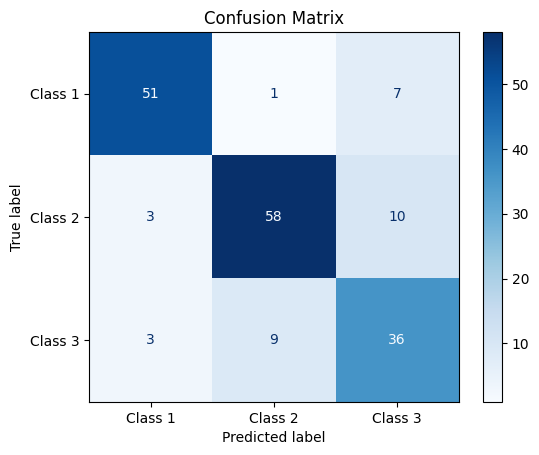

In [ ]:
# K-Folds Cross Validation to get predictions
predicted = cross_val_predict(multi_clf, x, y, cv=5) # Make predictions

# Calculate the confusion matrix using true labels and predictions
confusion_mat = confusion_matrix(y, predicted)

# Create a ConfusionMatrixDisplay object and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["Class 1", "Class 2", "Class 3"]) # Labels of the classes
disp.plot(cmap=plt.cm.Blues) # Colour
plt.title("Confusion Matrix")
plt.show()

### Use all the features

In [ ]:
# keep all the classes
# keep all the features
x = wine_dataframe.iloc[:, 1:].values
y = wine_dataframe.iloc[:, 0].values

print(x.shape)
print(y.shape)

(178, 13)
(178,)


In [ ]:
# K-Folds Cross Validation, k=5
# Multiclass Classification, ove-vs-one
clf = svm.SVC(kernel='linear')
multi_clf = OneVsOneClassifier(clf)

scores = cross_val_score(multi_clf, x, y, cv=5)
errors = 1 - scores

In [ ]:
mean_error = np.mean(errors)
print(f"Mean classification error is {round(mean_error, 4)}")

Mean classification error is 0.0389


In [ ]:
mean_acc = np.mean(scores)
print(f"Mean classification accuracy is {round(mean_acc*100, 2)}%")

Mean classification accuracy is 96.11%


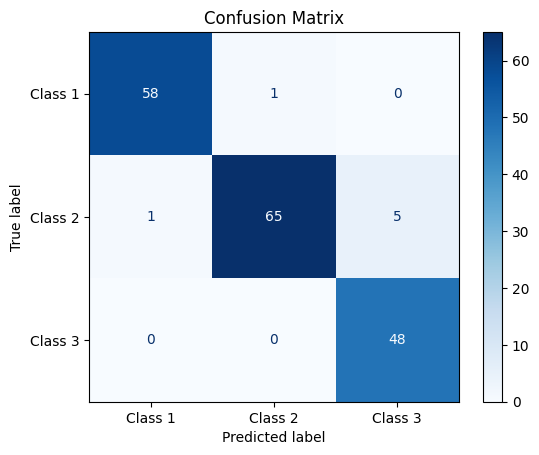

In [ ]:
# K-Folds Cross Validation to get predictions
predicted = cross_val_predict(multi_clf, x, y, cv=5)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y, predicted)

# Create a ConfusionMatrixDisplay object and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["Class 1", "Class 2", "Class 3"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()